# Matching

## Imports

In [1]:
import numpy as np
import uproot
import vector
import awkward as ak
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
import itertools
import pandas as pd
from upsetplot import UpSet, from_indicators, plot

directory = "/Users/archiebrooks/Downloads/"
#directory = "/Users/archiebrooks/Documents/Uni/mphys project/MPHYS-4Top/"
#directory = "c:/Users/matis/OneDrive/Documents/Y4/Project/"

hep.style.use('ATLAS')

## Functions and Maps

In [15]:
def histogram(data, bins, data_label, axes, density=False, ratio=False, ratio_axes=None, set_range = None, weight_array=None, x_units='GeV', print_peak=False, ttt_weights=None):
    if len(data[0]) != 1:
        if set_range is not None:
            global_min, global_max = set_range
        else:
            global_min = min([np.min(d) for d in data])
            global_max = max([np.max(d) for d in data])

        bin_edges = np.linspace(global_min, global_max, bins+1)
        counts = []
        errors = []
        bin_width = bin_edges[1]-bin_edges[0]
        for i in range(len(data)):
            if type(data[i])!= 'numpy.ndarray':
                data[i] = np.array(ak.to_numpy(data[i]))
            hist = bh.Histogram(bh.axis.Regular(bins, global_min, global_max))
            if (ttt_weights != None)&(i==1):
                hist.fill(data[i], weight=ttt_weights)
            else:
                hist.fill(data[i], weight=weight_array[i]) if weight_array is not None else hist.fill(data[i])
            norm_factor = np.sum(hist.counts() * np.diff(hist.axes[0].edges))
            if density: hep.histplot(hist.counts()/norm_factor, hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances())/norm_factor,label=data_label[i], histtype='step')
            else: hep.histplot(hist.counts(), hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances()),label=data_label[i], histtype='step')
            counts.append(hist.counts()/norm_factor) if density else counts.append(hist.counts())
            errors.append(np.sqrt(hist.variances())/norm_factor) if density else errors.append(np.sqrt(hist.variances()))       
            if print_peak:
                peak_bin_index = np.argmax(hist.counts())
                peak_bin_center = (hist.axes[0].edges[peak_bin_index] + hist.axes[0].edges[peak_bin_index + 1]) / 2
                print(f"Peak bin center for {data_label[i]}: {peak_bin_center:.2f} {x_units}")
    else:
        hist = bh.Histogram(bh.axis.Regular(bins, global_min, global_max))
        hist.fill(data)
        hep.histplot(hist.view(), hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances()), label=data_label, histtype='step')
        if print_peak:
                peak_bin_index = np.argmax(hist.counts())
                peak_bin_center = (hist.axes[0].edges[peak_bin_index] + hist.axes[0].edges[peak_bin_index + 1]) / 2
                print(f"Peak bin center for {data_label}: {peak_bin_center:.2f} {x_units}")

    bin_width = hist.axes[0].edges[1]-hist.axes[0].edges[0]
    axes.set_ylabel(f'Events /{bin_width:.2g} {x_units}')
    axes.legend()

    if ratio:
        reference_counts = counts[0]
        for i in range(1, len(counts)):
            ratio_values = np.divide(counts[i], reference_counts, out=np.zeros_like(counts[i]), where=reference_counts != 0)
            ratio_errors = np.sqrt(np.divide(errors[i],counts[i], out=np.zeros_like(counts[i]), where=counts[i]!=0)**2 + (np.divide(errors[0],counts[0], out=np.zeros_like(counts[0]), where=counts[0]!=0)**2))
            hep.histplot(ratio_values, bin_edges, ax=ratio_axes, yerr=ratio_errors, label=f'{data_label[i]}/{data_label[0]}')
        ratio_axes.set_ylabel("Ratio")
        ratio_axes.set_xlabel(axes.get_xlabel())
        ratio_axes.axhline(1, color='black', linestyle='--')  # Reference line at ratio=1
        ratio_axes.legend()
        if ratio_axes.get_ylim()[1]>5:
            ratio_axes.set_ylim(0,5)

    hep.atlas.label(ax=axes)

def n_combinations(particles, n, dictionary, type):
    i = n
    while len(particles[ak.num(particles)>=i])!=0:
        particles_i = particles[ak.num(particles)==i]
        if len(particles_i)==0:
            i+=1
            continue
        indices = np.array(list(itertools.combinations(range(np.shape(particles_i)[1]), n)))
        dictionary[type+f'_{i}'] = particles_i[:, indices]
        i += 1
    return None


mass_lookup = {
    1: 2.16E-3,
    2: 4.7E-3,
    3: 1.273,
    4: 93.5E-3,
    5: 172.57,
    6: 4.183,
    11: 0.511E-3,
    12: 0,
    13: 105.66E-3,
    14: 0,
    15: 1.77693,
    16: 0,
    21: 0
}

"""
def truth_correction(truth_ids, masked_indices, top_channel):
    if top_channel == "4t":
        
        truth_ids = ak.where(((((truth_ids==6)|(truth_ids==7))&(ak.any(masked_indices==0,axis=1))&(ak.all(masked_indices!=1,axis=1)))|
                                               ((truth_ids==6)&(ak.any(masked_indices==0,axis=1))&(ak.any(masked_indices==1,axis=1)))|
                            (((truth_ids==8)|(truth_ids==9))&(((ak.any(masked_indices==0,axis=1))&(ak.all(masked_indices!=1,axis=1))&(ak.all(masked_indices!=3, axis=1)))|
                                                              ((ak.all(masked_indices!=0,axis=1))&(ak.any(masked_indices==2,axis=1))&(ak.all(masked_indices!=3,axis=1)))))|
                                             ((truth_ids==8)&(((ak.any(masked_indices==0,axis=1))&(ak.all(masked_indices!=1,axis=1))&(ak.any(masked_indices==3, axis=1)))|
                                                              ((ak.all(masked_indices!=0,axis=1))&(ak.any(masked_indices==2,axis=1))&(ak.any(masked_indices==3,axis=1)))))|
                          (((truth_ids==10)|(truth_ids==11))&(((ak.any(masked_indices==0,axis=1))&(ak.all(masked_indices!=1,axis=1))&(ak.all(masked_indices!=3,axis=1))&(ak.all(masked_indices!=5,axis=1)))|
                                                              ((ak.all(masked_indices!=0,axis=1))&(ak.any(masked_indices==2,axis=1))&(ak.all(masked_indices!=3,axis=1))&(ak.all(masked_indices!=5,axis=1)))|
                                                              ((ak.all(masked_indices!=0,axis=1))&(ak.all(masked_indices!=2,axis=1))&(ak.any(masked_indices==4,axis=1))&(ak.all(masked_indices!=5,axis=1)))))|
                                            ((truth_ids==10)&(((ak.any(masked_indices==0,axis=1))&(ak.all(masked_indices!=1,axis=1))&(ak.all(masked_indices!=3,axis=1))&(ak.any(masked_indices==5,axis=1)))|
                                                              ((ak.all(masked_indices!=0,axis=1))&(ak.any(masked_indices==2,axis=1))&(ak.all(masked_indices!=3,axis=1))&(ak.any(masked_indices==5,axis=1)))|
                                                              ((ak.all(masked_indices!=0,axis=1))&(ak.all(masked_indices!=2,axis=1))&(ak.any(masked_indices==4,axis=1))&(ak.any(masked_indices==5,axis=1)))))), truth_ids+1, truth_ids)

        truth_ids = ak.where(((((truth_ids==7)|(truth_ids==8))&(ak.any(masked_indices==0,axis=1))&(ak.any(masked_indices==1,axis=1))&(ak.all(masked_indices!=2,axis=1)))|
                                               ((truth_ids==7)&(ak.any(masked_indices==0,axis=1))&(ak.any(masked_indices==1,axis=1))&(ak.any(masked_indices==2,axis=1)))|
                           (((truth_ids==9)|(truth_ids==10))&(((ak.any(masked_indices==0,axis=1))&(ak.any(masked_indices==1,axis=1))&(ak.all(masked_indices!=2,axis=1))&(ak.all(masked_indices!=4,axis=1)))|
                                                              ((ak.any(masked_indices==0,axis=1))&(ak.all(masked_indices!=1,axis=1))&(ak.any(masked_indices==3,axis=1))&(ak.all(masked_indices!=4,axis=1)))|
                                                              ((ak.all(masked_indices!=0,axis=1))&(ak.any(masked_indices==2,axis=1))&(ak.any(masked_indices==3,axis=1))&(ak.all(masked_indices!=4,axis=1)))))|
                                             ((truth_ids==9)&(((ak.any(masked_indices==0,axis=1))&(ak.any(masked_indices==1,axis=1))&(ak.all(masked_indices!=2,axis=1))&(ak.any(masked_indices==4,axis=1)))|
                                                              ((ak.any(masked_indices==0,axis=1))&(ak.all(masked_indices!=1,axis=1))&(ak.any(masked_indices==2,axis=1))&(ak.any(masked_indices==4,axis=1)))|
                                                              ((ak.all(masked_indices!=0,axis=1))&(ak.any(masked_indices==2,axis=1))&(ak.any(masked_indices==3,axis=1))&(ak.any(masked_indices==4,axis=1)))))), truth_ids+2, truth_ids)

        truth_ids = ak.where(((((truth_ids==8)|(truth_ids==9))&(ak.any(masked_indices==0,axis=1))&(ak.any(masked_indices==1,axis=1))&(ak.any(masked_indices==2, axis=1))&(ak.all(masked_indices!=3, axis=1)))|
                                               ((truth_ids==8)&(ak.any(masked_indices==0,axis=1))&(ak.any(masked_indices==1,axis=1))&(ak.any(masked_indices==2, axis=1)))), truth_ids+3, truth_ids)

    elif top_channel == "3t":
        
        truth_ids = ak.where(((((truth_ids==5)|(truth_ids==6))&(ak.any(masked_indices==0,axis=1))&(ak.all(masked_indices!=1,axis=1)))|
                                               ((truth_ids==5)&(ak.any(masked_indices==0,axis=1))&(ak.any(masked_indices==1,axis=1)))|
                            (((truth_ids==7)|(truth_ids==8))&(((ak.any(masked_indices==0,axis=1))&(ak.all(masked_indices!=1,axis=1))&(ak.all(masked_indices!=3, axis=1)))|
                                                              ((ak.all(masked_indices!=0,axis=1))&(ak.any(masked_indices==2,axis=1))&(ak.all(masked_indices!=3,axis=1)))))|
                                             ((truth_ids==7)&(((ak.any(masked_indices==0,axis=1))&(ak.all(masked_indices!=1,axis=1))&(ak.any(masked_indices==3, axis=1)))|
                                                              ((ak.all(masked_indices!=0,axis=1))&(ak.any(masked_indices==2,axis=1))&(ak.any(masked_indices==3,axis=1)))))), truth_ids+1, truth_ids)
                          
        truth_ids = ak.where(((((truth_ids==6)|(truth_ids==7))&(ak.any(masked_indices==0,axis=1))&(ak.any(masked_indices==1,axis=1))&(ak.all(masked_indices!=2,axis=1)))|
                                               ((truth_ids==6)&(ak.any(masked_indices==0,axis=1))&(ak.any(masked_indices==1,axis=1))&(ak.any(masked_indices==2,axis=1)))), truth_ids+2, truth_ids)

    else: print('Top Channel not recognised')

    return truth_ids
"""

def truth_correction(truth_ids, sorted_padded_indices, top_channel):

    if top_channel == "4t":
        truth_ids = ak.where((((truth_ids>=6)&(sorted_padded_indices[:,0]==0))|
                              ((truth_ids>=8)&(sorted_padded_indices[:,0]==2))|
                             ((truth_ids>=10)&(sorted_padded_indices[:,0]==4))), truth_ids+1, truth_ids)

        truth_ids = ak.where((((truth_ids>=8)&(sorted_padded_indices[:,1]==1))|
                             ((truth_ids>=10)&(sorted_padded_indices[:,1]==3))), truth_ids+1, truth_ids)

        truth_ids = ak.where(((truth_ids>=10)&(sorted_padded_indices[:,2]==2)), truth_ids+1, truth_ids)

    elif top_channel == "3t":
        truth_ids = ak.where((((truth_ids>=5)&(sorted_padded_indices[:,0]==0))|
                              ((truth_ids>=7)&(sorted_padded_indices[:,0]==2))), truth_ids+1, truth_ids)

        truth_ids = ak.where((((truth_ids>=7)&(sorted_padded_indices[:,1]==1))), truth_ids+1, truth_ids)

    return truth_ids

def top_identifier(reco, masked_indices, top_channel):
    indices = ak.fill_none(ak.pad_none(ak.sort(masked_indices), ak.max(ak.num(masked_indices))), -5)
    truth_ids = truth_correction(reco['truth id'], indices, top_channel)
    reco['truth id'] = truth_ids
    
    if top_channel == "4t":
        reco_tops_1_jet = ak.mask(reco[((truth_ids==1)|(truth_ids==5)|(truth_ids==6))],(ak.all(masked_indices!=0, axis=1)))
        reco_tops_1_lepton = ak.mask(reco[((truth_ids==1)|(truth_ids==5))],(ak.any(masked_indices==0, axis=1)))
        reco_tops_2_jet = ak.mask(reco[(truth_ids==2)|(truth_ids==7)|(truth_ids==8)], (((ak.all(masked_indices!=0, axis=1)) & (ak.all(masked_indices!=2, axis=1)))|
                                                                                        ((ak.any(masked_indices==0, axis=1)) & (ak.all(masked_indices!=1, axis=1)))))
        reco_tops_2_lepton = ak.mask(reco[(truth_ids==2)|(truth_ids==7)], (((ak.all(masked_indices!=0, axis=1)) & (ak.any(masked_indices==2, axis=1)))|
                                                                           ((ak.any(masked_indices==0, axis=1)) & (ak.any(masked_indices==1, axis=1)))))
        reco_tops_3_jet = ak.mask(reco[(truth_ids==3)|(truth_ids==9)|(truth_ids==10)], (((ak.all(masked_indices!=0, axis=1)) & (ak.all(masked_indices!=2, axis=1)) & (ak.all(masked_indices!=4, axis=1)))|
                                                                                       (((ak.any(masked_indices==0, axis=1)) & (ak.all(masked_indices!=1, axis=1)) & (ak.all(masked_indices!=3, axis=1)))|(((ak.all(masked_indices!=0, axis=1)) & (ak.any(masked_indices==2, axis=1))) & (ak.all(masked_indices!=3, axis=1))))|
                                                                                        ((ak.any(masked_indices==0, axis=1)) & (ak.any(masked_indices==1, axis=1)) & (ak.all(masked_indices!=2, axis=1)))))
        reco_tops_3_lepton = ak.mask(reco[(truth_ids==3)|(truth_ids==9)], (((ak.all(masked_indices!=0, axis=1)) & (ak.all(masked_indices!=2, axis=1)) & (ak.any(masked_indices==4, axis=1)))|
                                                                          (((ak.any(masked_indices==0, axis=1)) & (ak.all(masked_indices!=1, axis=1)) & (ak.any(masked_indices==3, axis=1)))|(((ak.all(masked_indices!=0, axis=1)) & (ak.any(masked_indices==2, axis=1))) & (ak.any(masked_indices==3, axis=1))))|
                                                                           ((ak.any(masked_indices==0, axis=1)) & (ak.any(masked_indices==1, axis=1)) & (ak.any(masked_indices==2, axis=1)))))

        reco_tops_4_jet = ak.mask(reco[(truth_ids==4)|(truth_ids==11)|(truth_ids==12)], (((ak.all(masked_indices!=0,axis=1))&(ak.all(masked_indices!=2,axis=1))&(ak.all(masked_indices!=4,axis=1))&(ak.all(masked_indices!=6,axis=1)))|
                                                                                         (((ak.any(masked_indices==0,axis=1))&(ak.all(masked_indices!=1,axis=1))&(ak.all(masked_indices!=3,axis=1))&(ak.all(masked_indices!=5,axis=1)))|((ak.all(masked_indices!=0, axis=1))&(ak.any(masked_indices==2,axis=1))&(ak.all(masked_indices!=3,axis=1))&(ak.all(masked_indices!=5,axis=1)))|((ak.all(masked_indices!=0,axis=1))&(ak.all(masked_indices!=2,axis=1))&(ak.any(masked_indices==4,axis=1))&(ak.all(masked_indices!=5,axis=1))))|
                                                                                         (((ak.any(masked_indices==0,axis=1))&(ak.any(masked_indices==1,axis=1))&(ak.all(masked_indices!=2,axis=1))&(ak.all(masked_indices!=4,axis=1)))|((ak.all(masked_indices!=0, axis=1))&(ak.any(masked_indices==2,axis=1))&(ak.any(masked_indices==3,axis=1))&(ak.all(masked_indices!=4,axis=1)))|((ak.any(masked_indices==0,axis=1))&(ak.all(masked_indices!=1,axis=1))&(ak.any(masked_indices==3,axis=1))&(ak.all(masked_indices!=4,axis=1))))|
                                                                                          ((ak.any(masked_indices==0,axis=1))&(ak.any(masked_indices==1,axis=1))&(ak.any(masked_indices==2,axis=1))&(ak.all(masked_indices!=3,axis=1)))))
        reco_tops_4_lepton = ak.mask(reco[(truth_ids==4)|(truth_ids==11)], (((ak.all(masked_indices!=0,axis=1))&(ak.all(masked_indices!=2,axis=1))&(ak.all(masked_indices!=4,axis=1))&(ak.any(masked_indices==6,axis=1)))|
                                                                           (((ak.any(masked_indices==0,axis=1))&(ak.all(masked_indices!=1,axis=1))&(ak.all(masked_indices!=3,axis=1))&(ak.any(masked_indices==5,axis=1)))|((ak.all(masked_indices!=0, axis=1))&(ak.any(masked_indices==2,axis=1))&(ak.all(masked_indices!=3,axis=1))&(ak.any(masked_indices==5,axis=1)))|((ak.all(masked_indices!=0,axis=1))&(ak.all(masked_indices!=2,axis=1))&(ak.any(masked_indices==4,axis=1))&(ak.any(masked_indices==5,axis=1))))|
                                                                           (((ak.any(masked_indices==0,axis=1))&(ak.any(masked_indices==1,axis=1))&(ak.all(masked_indices!=2,axis=1))&(ak.any(masked_indices==4,axis=1)))|((ak.all(masked_indices!=0, axis=1))&(ak.any(masked_indices==2,axis=1))&(ak.any(masked_indices==3,axis=1))&(ak.any(masked_indices==4,axis=1)))|((ak.any(masked_indices==0,axis=1))&(ak.all(masked_indices!=1,axis=1))&(ak.any(masked_indices==3,axis=1))&(ak.any(masked_indices==4,axis=1))))|
                                                                            ((ak.any(masked_indices==0,axis=1))&(ak.any(masked_indices==1,axis=1))&(ak.any(masked_indices==2,axis=1))&(ak.any(masked_indices==3,axis=1)))))
        
        masked_tops_1_lepton = ak.unflatten(ak.sum(ak.mask(reco_tops_1_lepton['reco'], ak.num(reco_tops_1_lepton['reco id'])==2), axis=1), 1)
        lepton_ids_truth_1 = ak.mask(reco_tops_1_lepton['truth id'], ak.num(reco_tops_1_lepton['truth id'])==2)
        lepton_ids_reco_1 = ak.mask(reco_tops_1_lepton['reco id'], ak.num(reco_tops_1_lepton['reco id'])==2)

        masked_tops_2_lepton = ak.unflatten(ak.sum(ak.mask(reco_tops_2_lepton['reco'], ak.num(reco_tops_2_lepton['reco id'])==2), axis=1), 1)
        lepton_ids_truth_2 = ak.mask(reco_tops_2_lepton['truth id'], ak.num(reco_tops_2_lepton['truth id'])==2)
        lepton_ids_reco_2 = ak.mask(reco_tops_2_lepton['reco id'], ak.num(reco_tops_2_lepton['reco id'])==2)

        masked_tops_3_lepton = ak.unflatten(ak.sum(ak.mask(reco_tops_3_lepton['reco'], ak.num(reco_tops_3_lepton['reco id'])==2), axis=1), 1)
        lepton_ids_truth_3 = ak.mask(reco_tops_3_lepton['truth id'], ak.num(reco_tops_3_lepton['truth id'])==2)
        lepton_ids_reco_3 = ak.mask(reco_tops_3_lepton['reco id'], ak.num(reco_tops_3_lepton['reco id'])==2)

        masked_tops_4_lepton = ak.unflatten(ak.sum(ak.mask(reco_tops_4_lepton['reco'], ak.num(reco_tops_4_lepton['reco id'])==2), axis=1), 1)
        lepton_ids_truth_4 = ak.mask(reco_tops_4_lepton['truth id'], ak.num(reco_tops_4_lepton['truth id'])==2)
        lepton_ids_reco_4 = ak.mask(reco_tops_4_lepton['reco id'], ak.num(reco_tops_4_lepton['reco id'])==2)

        masked_top_1_jet = ak.unflatten(ak.sum(ak.mask(reco_tops_1_jet['reco'], ak.num(reco_tops_1_jet)==3), axis=1), 1)
        jet_ids_truth_1 = ak.mask(reco_tops_1_jet['truth id'], ak.num(reco_tops_1_jet['truth id'])==3)
        jet_ids_reco_1 = ak.mask(reco_tops_1_jet['reco id'], ak.num(reco_tops_1_jet['reco id'])==3)

        masked_top_2_jet = ak.unflatten(ak.sum(ak.mask(reco_tops_2_jet['reco'], ak.num(reco_tops_2_jet['reco id'])==3), axis=1), 1)
        jet_ids_truth_2 = ak.mask(reco_tops_2_jet['truth id'], ak.num(reco_tops_2_jet['truth id'])==3)
        jet_ids_reco_2 = ak.mask(reco_tops_2_jet['reco id'], ak.num(reco_tops_2_jet['reco id'])==3)

        masked_top_3_jet = ak.unflatten(ak.sum(ak.mask(reco_tops_3_jet['reco'], ak.num(reco_tops_3_jet['reco id'])==3), axis=1), 1)
        jet_ids_truth_3 = ak.mask(reco_tops_3_jet['truth id'], ak.num(reco_tops_3_jet['truth id'])==3)
        jet_ids_reco_3 = ak.mask(reco_tops_3_jet['reco id'], ak.num(reco_tops_3_jet['reco id'])==3)

        masked_top_4_jet = ak.unflatten(ak.sum(ak.mask(reco_tops_4_jet['reco'], ak.num(reco_tops_4_jet['reco id'])==3), axis=1), 1)
        jet_ids_truth_4 = ak.mask(reco_tops_4_jet['truth id'], ak.num(reco_tops_4_jet['truth id'])==3)
        jet_ids_reco_4 = ak.mask(reco_tops_4_jet['reco id'], ak.num(reco_tops_4_jet['reco id'])==3)

        hadronic_tops = ak.drop_none(ak.concatenate((masked_top_1_jet,masked_top_2_jet,masked_top_3_jet,masked_top_4_jet), axis=1))
        hadronic_reco_ids = ak.drop_none(ak.concatenate((jet_ids_reco_1,jet_ids_reco_2,jet_ids_reco_3,jet_ids_reco_4), axis=1))
        hadronic_truth_ids = ak.drop_none(ak.concatenate((jet_ids_truth_1,jet_ids_truth_2,jet_ids_truth_3,jet_ids_truth_4), axis=1))
        leptonic_tops = ak.drop_none(ak.concatenate((masked_tops_1_lepton,masked_tops_2_lepton,masked_tops_3_lepton,masked_tops_4_lepton), axis=1))
        leptonic_reco_ids = ak.drop_none(ak.concatenate((lepton_ids_reco_1,lepton_ids_reco_2,lepton_ids_reco_3,lepton_ids_reco_4), axis=1))
        leptonic_truth_ids = ak.drop_none(ak.concatenate((lepton_ids_truth_1,lepton_ids_truth_2,lepton_ids_truth_3,lepton_ids_truth_4), axis=1))
    
    elif top_channel == "3t":
        reco_tops_1_jet = ak.mask(reco[((truth_ids==1)|(truth_ids==4)|(truth_ids==5))],(ak.all(masked_indices!=0, axis=1)))
        reco_tops_1_lepton = ak.mask(reco[((truth_ids==1)|(truth_ids==4))],(ak.any(masked_indices==0, axis=1)))
        reco_tops_2_jet = ak.mask(reco[(truth_ids==2)|(truth_ids==6)|(truth_ids==7)], (((ak.all(masked_indices!=0, axis=1)) & (ak.all(masked_indices!=2, axis=1)))|
                                                                                        ((ak.any(masked_indices==0, axis=1)) & (ak.all(masked_indices!=1, axis=1)))))
        reco_tops_2_lepton = ak.mask(reco[(truth_ids==2)|(truth_ids==6)], (((ak.all(masked_indices!=0, axis=1)) & (ak.any(masked_indices==2, axis=1)))|
                                                                           ((ak.any(masked_indices==0, axis=1)) & (ak.any(masked_indices==1, axis=1)))))
        reco_tops_3_jet = ak.mask(reco[(truth_ids==3)|(truth_ids==8)|(truth_ids==9)], (((ak.all(masked_indices!=0, axis=1)) & (ak.all(masked_indices!=2, axis=1)) & (ak.all(masked_indices!=4, axis=1)))|
                                                                                       (((ak.any(masked_indices==0, axis=1)) & (ak.all(masked_indices!=1, axis=1)) & (ak.all(masked_indices!=3, axis=1)))|(((ak.all(masked_indices!=0, axis=1)) & (ak.any(masked_indices==2, axis=1))) & (ak.all(masked_indices!=3, axis=1))))|
                                                                                        ((ak.any(masked_indices==0, axis=1)) & (ak.any(masked_indices==1, axis=1)) & (ak.all(masked_indices!=2, axis=1)))))
        reco_tops_3_lepton = ak.mask(reco[(truth_ids==3)|(truth_ids==8)], (((ak.all(masked_indices!=0, axis=1)) & (ak.all(masked_indices!=2, axis=1)) & (ak.any(masked_indices==4, axis=1)))|
                                                                          (((ak.any(masked_indices==0, axis=1)) & (ak.all(masked_indices!=1, axis=1)) & (ak.any(masked_indices==3, axis=1)))|(((ak.all(masked_indices!=0, axis=1)) & (ak.any(masked_indices==2, axis=1))) & (ak.any(masked_indices==3, axis=1))))|
                                                                           ((ak.any(masked_indices==0, axis=1)) & (ak.any(masked_indices==1, axis=1)) & (ak.any(masked_indices==2, axis=1)))))

        masked_tops_1_lepton = ak.unflatten(ak.sum(ak.mask(reco_tops_1_lepton['reco'], ak.num(reco_tops_1_lepton['reco id'])==2), axis=1), 1)
        lepton_ids_truth_1 = ak.mask(reco_tops_1_lepton['truth id'], ak.num(reco_tops_1_lepton['truth id'])==2)
        lepton_ids_reco_1 = ak.mask(reco_tops_1_lepton['reco id'], ak.num(reco_tops_1_lepton['reco id'])==2)

        masked_tops_2_lepton = ak.unflatten(ak.sum(ak.mask(reco_tops_2_lepton['reco'], ak.num(reco_tops_2_lepton['reco id'])==2), axis=1), 1)
        lepton_ids_truth_2 = ak.mask(reco_tops_2_lepton['truth id'], ak.num(reco_tops_2_lepton['truth id'])==2)
        lepton_ids_reco_2 = ak.mask(reco_tops_2_lepton['reco id'], ak.num(reco_tops_2_lepton['reco id'])==2)

        masked_tops_3_lepton = ak.unflatten(ak.sum(ak.mask(reco_tops_3_lepton['reco'], ak.num(reco_tops_3_lepton['reco id'])==2), axis=1), 1)
        lepton_ids_truth_3 = ak.mask(reco_tops_3_lepton['truth id'], ak.num(reco_tops_3_lepton['truth id'])==2)
        lepton_ids_reco_3 = ak.mask(reco_tops_3_lepton['reco id'], ak.num(reco_tops_3_lepton['reco id'])==2)

        masked_top_1_jet = ak.unflatten(ak.sum(ak.mask(reco_tops_1_jet['reco'], ak.num(reco_tops_1_jet)==3), axis=1), 1)
        jet_ids_truth_1 = ak.mask(reco_tops_1_jet['truth id'], ak.num(reco_tops_1_jet['truth id'])==3)
        jet_ids_reco_1 = ak.mask(reco_tops_1_jet['reco id'], ak.num(reco_tops_1_jet['reco id'])==3)

        masked_top_2_jet = ak.unflatten(ak.sum(ak.mask(reco_tops_2_jet['reco'], ak.num(reco_tops_2_jet['reco id'])==3), axis=1), 1)
        jet_ids_truth_2 = ak.mask(reco_tops_2_jet['truth id'], ak.num(reco_tops_2_jet['truth id'])==3)
        jet_ids_reco_2 = ak.mask(reco_tops_2_jet['reco id'], ak.num(reco_tops_2_jet['reco id'])==3)

        masked_top_3_jet = ak.unflatten(ak.sum(ak.mask(reco_tops_3_jet['reco'], ak.num(reco_tops_3_jet['reco id'])==3), axis=1), 1)
        jet_ids_truth_3 = ak.mask(reco_tops_3_jet['truth id'], ak.num(reco_tops_3_jet['truth id'])==3)
        jet_ids_reco_3 = ak.mask(reco_tops_3_jet['reco id'], ak.num(reco_tops_3_jet['reco id'])==3)

        hadronic_tops = ak.drop_none(ak.concatenate((masked_top_1_jet,masked_top_2_jet,masked_top_3_jet), axis=1))
        hadronic_reco_ids = ak.drop_none(ak.concatenate((jet_ids_reco_1,jet_ids_reco_2,jet_ids_reco_3), axis=1))
        hadronic_truth_ids = ak.drop_none(ak.concatenate((jet_ids_truth_1,jet_ids_truth_2,jet_ids_truth_3), axis=1))
        leptonic_tops = ak.drop_none(ak.concatenate((masked_tops_1_lepton,masked_tops_2_lepton,masked_tops_3_lepton), axis=1))
        leptonic_reco_ids = ak.drop_none(ak.concatenate((lepton_ids_reco_1,lepton_ids_reco_2,lepton_ids_reco_3), axis=1))
        leptonic_truth_ids = ak.drop_none(ak.concatenate((lepton_ids_truth_1,lepton_ids_truth_2,lepton_ids_truth_3), axis=1))
        
    tops = ak.concatenate((hadronic_tops,leptonic_tops), axis=1)
    top_reco_ids = ak.concatenate((hadronic_reco_ids,leptonic_reco_ids), axis=1)
    top_truth_ids = ak.concatenate((hadronic_truth_ids,leptonic_truth_ids), axis=1)

    return [hadronic_tops, hadronic_reco_ids, hadronic_truth_ids], [leptonic_tops, leptonic_reco_ids, leptonic_truth_ids], [tops, top_reco_ids, top_truth_ids]

def w_identifier(reco, masked_indices, top_channel):
    indices = ak.fill_none(ak.pad_none(ak.sort(masked_indices), ak.max(ak.num(masked_indices))), -5)
    truth_ids = truth_correction(reco['truth id'], indices, top_channel)
    reco['truth id'] = truth_ids
    
    if top_channel == "4t":
        reco_ws_1_jet = ak.mask(reco[((truth_ids==5)|(truth_ids==6))],(ak.all(masked_indices!=0, axis=1)))
        reco_ws_1_lepton = ak.mask(reco[((truth_ids==5))],(ak.any(masked_indices==0, axis=1)))
        reco_ws_2_jet = ak.mask(reco[(truth_ids==7)|(truth_ids==8)], (((ak.all(masked_indices!=0, axis=1)) & (ak.all(masked_indices!=2, axis=1)))|
                                                                                        ((ak.any(masked_indices==0, axis=1)) & (ak.all(masked_indices!=1, axis=1)))))
        reco_ws_2_lepton = ak.mask(reco[(truth_ids==7)], (((ak.all(masked_indices!=0, axis=1)) & (ak.any(masked_indices==2, axis=1)))|
                                                                           ((ak.any(masked_indices==0, axis=1)) & (ak.any(masked_indices==1, axis=1)))))
        reco_ws_3_jet = ak.mask(reco[(truth_ids==9)|(truth_ids==10)], (((ak.all(masked_indices!=0, axis=1)) & (ak.all(masked_indices!=2, axis=1)) & (ak.all(masked_indices!=4, axis=1)))|
                                                                                       (((ak.any(masked_indices==0, axis=1)) & (ak.all(masked_indices!=1, axis=1)) & (ak.all(masked_indices!=3, axis=1)))|(((ak.all(masked_indices!=0, axis=1)) & (ak.any(masked_indices==2, axis=1))) & (ak.all(masked_indices!=3, axis=1))))|
                                                                                        ((ak.any(masked_indices==0, axis=1)) & (ak.any(masked_indices==1, axis=1)) & (ak.all(masked_indices!=2, axis=1)))))
        reco_ws_3_lepton = ak.mask(reco[(truth_ids==9)], (((ak.all(masked_indices!=0, axis=1)) & (ak.all(masked_indices!=2, axis=1)) & (ak.any(masked_indices==4, axis=1)))|
                                                                          (((ak.any(masked_indices==0, axis=1)) & (ak.all(masked_indices!=1, axis=1)) & (ak.any(masked_indices==3, axis=1)))|(((ak.all(masked_indices!=0, axis=1)) & (ak.any(masked_indices==2, axis=1))) & (ak.any(masked_indices==3, axis=1))))|
                                                                           ((ak.any(masked_indices==0, axis=1)) & (ak.any(masked_indices==1, axis=1)) & (ak.any(masked_indices==2, axis=1)))))

        reco_ws_4_jet = ak.mask(reco[(truth_ids==11)|(truth_ids==12)], (((ak.all(masked_indices!=0,axis=1))&(ak.all(masked_indices!=2,axis=1))&(ak.all(masked_indices!=4,axis=1))&(ak.all(masked_indices!=6,axis=1)))|
                                                                                         (((ak.any(masked_indices==0,axis=1))&(ak.all(masked_indices!=1,axis=1))&(ak.all(masked_indices!=3,axis=1))&(ak.all(masked_indices!=5,axis=1)))|((ak.all(masked_indices!=0, axis=1))&(ak.any(masked_indices==2,axis=1))&(ak.all(masked_indices!=3,axis=1))&(ak.all(masked_indices!=5,axis=1)))|((ak.all(masked_indices!=0,axis=1))&(ak.all(masked_indices!=2,axis=1))&(ak.any(masked_indices==4,axis=1))&(ak.all(masked_indices!=5,axis=1))))|
                                                                                         (((ak.any(masked_indices==0,axis=1))&(ak.any(masked_indices==1,axis=1))&(ak.all(masked_indices!=2,axis=1))&(ak.all(masked_indices!=4,axis=1)))|((ak.all(masked_indices!=0, axis=1))&(ak.any(masked_indices==2,axis=1))&(ak.any(masked_indices==3,axis=1))&(ak.all(masked_indices!=4,axis=1)))|((ak.any(masked_indices==0,axis=1))&(ak.all(masked_indices!=1,axis=1))&(ak.any(masked_indices==3,axis=1))&(ak.all(masked_indices!=4,axis=1))))|
                                                                                          ((ak.any(masked_indices==0,axis=1))&(ak.any(masked_indices==1,axis=1))&(ak.any(masked_indices==2,axis=1))&(ak.all(masked_indices!=3,axis=1)))))
        reco_ws_4_lepton = ak.mask(reco[(truth_ids==11)], (((ak.all(masked_indices!=0,axis=1))&(ak.all(masked_indices!=2,axis=1))&(ak.all(masked_indices!=4,axis=1))&(ak.any(masked_indices==6,axis=1)))|
                                                                           (((ak.any(masked_indices==0,axis=1))&(ak.all(masked_indices!=1,axis=1))&(ak.all(masked_indices!=3,axis=1))&(ak.any(masked_indices==5,axis=1)))|((ak.all(masked_indices!=0, axis=1))&(ak.any(masked_indices==2,axis=1))&(ak.all(masked_indices!=3,axis=1))&(ak.any(masked_indices==5,axis=1)))|((ak.all(masked_indices!=0,axis=1))&(ak.all(masked_indices!=2,axis=1))&(ak.any(masked_indices==4,axis=1))&(ak.any(masked_indices==5,axis=1))))|
                                                                           (((ak.any(masked_indices==0,axis=1))&(ak.any(masked_indices==1,axis=1))&(ak.all(masked_indices!=2,axis=1))&(ak.any(masked_indices==4,axis=1)))|((ak.all(masked_indices!=0, axis=1))&(ak.any(masked_indices==2,axis=1))&(ak.any(masked_indices==3,axis=1))&(ak.any(masked_indices==4,axis=1)))|((ak.any(masked_indices==0,axis=1))&(ak.all(masked_indices!=1,axis=1))&(ak.any(masked_indices==3,axis=1))&(ak.any(masked_indices==4,axis=1))))|
                                                                            ((ak.any(masked_indices==0,axis=1))&(ak.any(masked_indices==1,axis=1))&(ak.any(masked_indices==2,axis=1))&(ak.any(masked_indices==3,axis=1)))))

        masked_ws_1_lepton = ak.unflatten(ak.sum(ak.mask(reco_ws_1_lepton['reco'], ak.num(reco_ws_1_lepton['reco id'])==1), axis=1), 1)
        lepton_ids_truth_1 = ak.mask(reco_ws_1_lepton['truth id'], ak.num(reco_ws_1_lepton['truth id'])==1)
        lepton_ids_reco_1 = ak.mask(reco_ws_1_lepton['reco id'], ak.num(reco_ws_1_lepton['reco id'])==1)

        masked_ws_2_lepton = ak.unflatten(ak.sum(ak.mask(reco_ws_2_lepton['reco'], ak.num(reco_ws_2_lepton['reco id'])==1), axis=1), 1)
        lepton_ids_truth_2 = ak.mask(reco_ws_2_lepton['truth id'], ak.num(reco_ws_2_lepton['truth id'])==1)
        lepton_ids_reco_2 = ak.mask(reco_ws_2_lepton['reco id'], ak.num(reco_ws_2_lepton['reco id'])==1)

        masked_ws_3_lepton = ak.unflatten(ak.sum(ak.mask(reco_ws_3_lepton['reco'], ak.num(reco_ws_3_lepton['reco id'])==1), axis=1), 1)
        lepton_ids_truth_3 = ak.mask(reco_ws_3_lepton['truth id'], ak.num(reco_ws_3_lepton['truth id'])==1)
        lepton_ids_reco_3 = ak.mask(reco_ws_3_lepton['reco id'], ak.num(reco_ws_3_lepton['reco id'])==1)

        masked_ws_4_lepton = ak.unflatten(ak.sum(ak.mask(reco_ws_4_lepton['reco'], ak.num(reco_ws_4_lepton['reco id'])==1), axis=1), 1)
        lepton_ids_truth_4 = ak.mask(reco_ws_4_lepton['truth id'], ak.num(reco_ws_4_lepton['truth id'])==1)
        lepton_ids_reco_4 = ak.mask(reco_ws_4_lepton['reco id'], ak.num(reco_ws_4_lepton['reco id'])==1)

        masked_w_1_jet = ak.unflatten(ak.sum(ak.mask(reco_ws_1_jet['reco'], ak.num(reco_ws_1_jet['reco id'])==2), axis=1), 1)
        jet_ids_truth_1 = ak.mask(reco_ws_1_jet['truth id'], ak.num(reco_ws_1_jet['truth id'])==2)
        jet_ids_reco_1 = ak.mask(reco_ws_1_jet['reco id'], ak.num(reco_ws_1_jet['reco id'])==2)

        masked_w_2_jet = ak.unflatten(ak.sum(ak.mask(reco_ws_2_jet['reco'], ak.num(reco_ws_2_jet['reco id'])==2), axis=1), 1)
        jet_ids_truth_2 = ak.mask(reco_ws_2_jet['truth id'], ak.num(reco_ws_2_jet['truth id'])==2)
        jet_ids_reco_2 = ak.mask(reco_ws_2_jet['reco id'], ak.num(reco_ws_2_jet['reco id'])==2)

        masked_w_3_jet = ak.unflatten(ak.sum(ak.mask(reco_ws_3_jet['reco'], ak.num(reco_ws_3_jet['reco id'])==2), axis=1), 1)
        jet_ids_truth_3 = ak.mask(reco_ws_3_jet['truth id'], ak.num(reco_ws_3_jet['truth id'])==2)
        jet_ids_reco_3 = ak.mask(reco_ws_3_jet['reco id'], ak.num(reco_ws_3_jet['reco id'])==2)

        masked_w_4_jet = ak.unflatten(ak.sum(ak.mask(reco_ws_4_jet['reco'], ak.num(reco_ws_4_jet['reco id'])==2), axis=1), 1)
        jet_ids_truth_4 = ak.mask(reco_ws_4_jet['truth id'], ak.num(reco_ws_4_jet['truth id'])==2)
        jet_ids_reco_4 = ak.mask(reco_ws_4_jet['reco id'], ak.num(reco_ws_4_jet['reco id'])==2)

        hadronic_ws = ak.drop_none(ak.concatenate((masked_w_1_jet,masked_w_2_jet,masked_w_3_jet,masked_w_4_jet), axis=1))
        hadronic_reco_ids = ak.drop_none(ak.concatenate((jet_ids_reco_1,jet_ids_reco_2,jet_ids_reco_3,jet_ids_reco_4), axis=1))
        hadronic_truth_ids = ak.drop_none(ak.concatenate((jet_ids_truth_1,jet_ids_truth_2,jet_ids_truth_3,jet_ids_truth_4), axis=1))
        leptonic_ws = ak.drop_none(ak.concatenate((masked_ws_1_lepton,masked_ws_2_lepton,masked_ws_3_lepton,masked_ws_4_lepton), axis=1))
        leptonic_reco_ids = ak.drop_none(ak.concatenate((lepton_ids_reco_1,lepton_ids_reco_2,lepton_ids_reco_3,lepton_ids_reco_4), axis=1))
        leptonic_truth_ids = ak.drop_none(ak.concatenate((lepton_ids_truth_1,lepton_ids_truth_2,lepton_ids_truth_3,lepton_ids_truth_4), axis=1))
    
    elif top_channel == "3t":
        reco_ws_1_jet = ak.mask(reco[((truth_ids==4)|(truth_ids==5))],(ak.all(masked_indices!=0, axis=1)))
        reco_ws_1_lepton = ak.mask(reco[((truth_ids==4))],(ak.any(masked_indices==0, axis=1)))
        reco_ws_2_jet = ak.mask(reco[(truth_ids==6)|(truth_ids==7)], (((ak.all(masked_indices!=0, axis=1)) & (ak.all(masked_indices!=2, axis=1)))|
                                                                                        ((ak.any(masked_indices==0, axis=1)) & (ak.all(masked_indices!=1, axis=1)))))
        reco_ws_2_lepton = ak.mask(reco[(truth_ids==6)], (((ak.all(masked_indices!=0, axis=1)) & (ak.any(masked_indices==2, axis=1)))|
                                                                           ((ak.any(masked_indices==0, axis=1)) & (ak.any(masked_indices==1, axis=1)))))
        reco_ws_3_jet = ak.mask(reco[(truth_ids==8)|(truth_ids==9)], (((ak.all(masked_indices!=0, axis=1)) & (ak.all(masked_indices!=2, axis=1)) & (ak.all(masked_indices!=4, axis=1)))|
                                                                                       (((ak.any(masked_indices==0, axis=1)) & (ak.all(masked_indices!=1, axis=1)) & (ak.all(masked_indices!=3, axis=1)))|(((ak.all(masked_indices!=0, axis=1)) & (ak.any(masked_indices==2, axis=1))) & (ak.all(masked_indices!=3, axis=1))))|
                                                                                        ((ak.any(masked_indices==0, axis=1)) & (ak.any(masked_indices==1, axis=1)) & (ak.all(masked_indices!=2, axis=1)))))
        reco_ws_3_lepton = ak.mask(reco[(truth_ids==8)], (((ak.all(masked_indices!=0, axis=1)) & (ak.all(masked_indices!=2, axis=1)) & (ak.any(masked_indices==4, axis=1)))|
                                                                          (((ak.any(masked_indices==0, axis=1)) & (ak.all(masked_indices!=1, axis=1)) & (ak.any(masked_indices==3, axis=1)))|(((ak.all(masked_indices!=0, axis=1)) & (ak.any(masked_indices==2, axis=1))) & (ak.any(masked_indices==3, axis=1))))|
                                                                           ((ak.any(masked_indices==0, axis=1)) & (ak.any(masked_indices==1, axis=1)) & (ak.any(masked_indices==2, axis=1)))))

        masked_ws_1_lepton = ak.unflatten(ak.sum(ak.mask(reco_ws_1_lepton['reco'], ak.num(reco_ws_1_lepton['reco id'])==1), axis=1), 1)
        lepton_ids_truth_1 = ak.mask(reco_ws_1_lepton['truth id'], ak.num(reco_ws_1_lepton['truth id'])==1)
        lepton_ids_reco_1 = ak.mask(reco_ws_1_lepton['reco id'], ak.num(reco_ws_1_lepton['reco id'])==1)

        masked_ws_2_lepton = ak.unflatten(ak.sum(ak.mask(reco_ws_2_lepton['reco'], ak.num(reco_ws_2_lepton['reco id'])==1), axis=1), 1)
        lepton_ids_truth_2 = ak.mask(reco_ws_2_lepton['truth id'], ak.num(reco_tops_2_lepton['truth id'])==1)
        lepton_ids_reco_2 = ak.mask(reco_ws_2_lepton['reco id'], ak.num(reco_tops_2_lepton['reco id'])==1)

        masked_ws_3_lepton = ak.unflatten(ak.sum(ak.mask(reco_ws_3_lepton['reco'], ak.num(reco_ws_3_lepton['reco id'])==1), axis=1), 1)
        lepton_ids_truth_3 = ak.mask(reco_ws_3_lepton['truth id'], ak.num(reco_ws_3_lepton['truth id'])==2)
        lepton_ids_reco_3 = ak.mask(reco_ws_3_lepton['reco id'], ak.num(reco_ws_3_lepton['reco id'])==2)

        masked_w_1_jet = ak.unflatten(ak.sum(ak.mask(reco_ws_1_jet['reco'], ak.num(reco_ws_1_jet['reco id'])==2), axis=1), 1)
        jet_ids_truth_1 = ak.mask(reco_ws_1_jet['truth id'], ak.num(reco_ws_1_jet['truth id'])==2)
        jet_ids_reco_1 = ak.mask(reco_ws_1_jet['reco id'], ak.num(reco_ws_1_jet['reco id'])==2)

        masked_w_2_jet = ak.unflatten(ak.sum(ak.mask(reco_ws_2_jet['reco'], ak.num(reco_ws_2_jet['reco id'])==2), axis=1), 1)
        jet_ids_truth_2 = ak.mask(reco_ws_2_jet['truth id'], ak.num(reco_ws_2_jet['truth id'])==2)
        jet_ids_reco_2 = ak.mask(reco_ws_2_jet['reco id'], ak.num(reco_ws_2_jet['reco id'])==2)

        masked_w_3_jet = ak.unflatten(ak.sum(ak.mask(reco_ws_3_jet['reco'], ak.num(reco_ws_3_jet['reco id'])==2), axis=1), 1)
        jet_ids_truth_3 = ak.mask(reco_ws_3_jet['truth id'], ak.num(reco_ws_3_jet['truth id'])==2)
        jet_ids_reco_3 = ak.mask(reco_ws_3_jet['reco id'], ak.num(reco_ws_3_jet['reco id'])==2)

        hadronic_ws = ak.drop_none(ak.concatenate((masked_w_1_jet,masked_w_2_jet,masked_w_3_jet), axis=1))
        hadronic_reco_ids = ak.drop_none(ak.concatenate((jet_ids_reco_1,jet_ids_reco_2,jet_ids_reco_3), axis=1))
        hadronic_truth_ids = ak.drop_none(ak.concatenate((jet_ids_truth_1,jet_ids_truth_2,jet_ids_truth_3), axis=1))
        leptonic_tops = ak.drop_none(ak.concatenate((masked_ws_1_lepton,masked_ws_2_lepton,masked_ws_3_lepton), axis=1))
        leptonic_reco_ids = ak.drop_none(ak.concatenate((lepton_ids_reco_1,lepton_ids_reco_2,lepton_ids_reco_3), axis=1))
        leptonic_truth_ids = ak.drop_none(ak.concatenate((lepton_ids_truth_1,lepton_ids_truth_2,lepton_ids_truth_3), axis=1))
        
    ws = ak.concatenate((hadronic_ws,leptonic_ws), axis=1)
    w_reco_ids = ak.concatenate((hadronic_reco_ids,leptonic_reco_ids), axis=1)
    w_truth_ids = ak.concatenate((hadronic_truth_ids,leptonic_truth_ids), axis=1)

    return [hadronic_ws, hadronic_reco_ids, hadronic_truth_ids], [leptonic_ws, leptonic_reco_ids, leptonic_truth_ids], [ws, w_reco_ids, w_truth_ids]
    
def deltar_matching(truth, truth_id, reco_jets, reco_leptons):
    indexed_truth = ak.zip({'truth': truth, 'id': ak.local_index(truth)+1})
    truth_jets = indexed_truth[np.abs(truth_id) < 10]
    truth_leptons = indexed_truth[(np.abs(truth_id) > 10)&(np.abs(truth_id)<20)]
    
    jets_3d = ak.cartesian({'reco':reco_jets, 'truth': truth_jets}, axis=1, nested=True)
    deltars = jets_3d['reco'].deltaR(jets_3d['truth']['truth'])
    jet_mask = (ak.min(deltars,axis=2)==deltars)&(ak.min(deltars,axis=2)<0.4)
    matched_jets = ak.flatten(jets_3d[jet_mask], axis=2)

    leptons_3d = ak.cartesian({'truth': truth_leptons, 'reco':reco_leptons}, axis=1, nested=True)
    deltars = leptons_3d['reco'].deltaR(leptons_3d['truth']['truth'])
    lepton_mask = (ak.min(deltars,axis=2)==deltars)&(ak.min(deltars,axis=2)<0.1)
    matched_leptons = ak.flatten(leptons_3d[lepton_mask], axis=2)
    matched = ak.concatenate((matched_jets, matched_leptons), axis=1)
    truth_ids = matched['truth']['id']
    deduped_id_pairs = ak.Array([list(dict.fromkeys(row)) for row in ak.to_list(truth_ids)])
    no_repeats = ak.num(deduped_id_pairs) == ak.num(truth_ids)
    matched = matched[no_repeats]

    jet_ids_3d = ak.cartesian({'id': ak.local_index(reco_jets), 'truth': truth[np.abs(truth_id) < 10]})[no_repeats]
    lepton_ids_3d = ak.cartesian({'id': ak.local_index(reco_leptons) + ak.num(reco_jets), 'truth': truth[(np.abs(truth_id) > 10)&(np.abs(truth_id) < 20)]})[no_repeats]
    matched_jet_ids = jet_ids_3d['id'][ak.flatten(jet_mask[no_repeats], axis=2)]
    matched_lepton_ids = lepton_ids_3d['id'][ak.flatten(lepton_mask[no_repeats], axis=2)]
    
    return matched, matched_jet_ids, matched_lepton_ids, no_repeats

def save_awkward_to_csv(awk_array, filename):

    max_length = max(len(subarray) for subarray in ak.to_list(awk_array))
    
    # Pad with NaNs for uniform shape
    padded_array = ak.fill_none(ak.pad_none(awk_array, max_length, axis=1), np.nan)
    
    # Convert to Pandas DataFrame
    df = pd.DataFrame(ak.to_numpy(padded_array))
    
    # Save as CSV
    df.to_csv(filename, index=False)
    
    print(f"Awkward array saved to {filename}")

## Data

### 4 Top
#### Data

In [14]:
tree4 = uproot.open("4tops_parsed_combined_2811.root")
tree4_truth = tree4['Truth;1']
tree4_reco = tree4['Reco;1']

events_4t_truth = tree4_truth.arrays(['b_id', 'b_pt', 'b_eta', 'b_phi', 'b_e', 'b_mass', 'W_decay_id', 'W_decay_pt', 'W_decay_eta', 'W_decay_phi', 'W_decay_e', 'W_decay_mass'])
events_4t_t_neut = tree4_truth.arrays(['W_decay_id', 'W_decay_pt', 'W_decay_eta', 'W_decay_phi', 'W_decay_e', 'W_decay_mass'])
events_4t_partonic = tree4_truth.arrays(['top_pt', 'top_eta', 'top_phi', 'top_e', 'top_mass', 'top_id', 'W_pt', 'W_eta', 'W_phi', 'W_e', 'W_mass', 'W_id'])
events_4t_reco = tree4_reco.arrays(['jet_pt', 'jet_eta', 'jet_phi', 'jet_mass', 'jet_btag', 'el_pt', 'el_eta', 'el_phi', 'el_charge', 'mu_pt', 'mu_eta', 'mu_phi', 'mu_charge'])
events_4t_r_neut = tree4_reco.arrays(['met_met', 'met_eta', 'met_phi'])

events_4t_reco['el_mass'] = 0.511e-3 * np.ones_like(events_4t_reco['el_pt'])
events_4t_reco['mu_mass'] = 0.1057 * np.ones_like(events_4t_reco['mu_pt'])
events_4t_reco['jet_e'] = np.sqrt(events_4t_reco['jet_mass']**2+(events_4t_reco['jet_pt']**2)*(np.cosh(events_4t_reco['jet_eta']))**2)
events_4t_reco['el_e'] = np.sqrt(events_4t_reco['el_mass']**2+(events_4t_reco['el_pt']**2)*(np.cosh(events_4t_reco['el_eta']))**2)
events_4t_reco['mu_e'] = np.sqrt(events_4t_reco['mu_mass']**2+(events_4t_reco['mu_pt']**2)*(np.cosh(events_4t_reco['mu_eta']))**2)
events_4t_r_neut['met_e'] = (events_4t_r_neut['met_met'])*(np.cosh(events_4t_r_neut['met_eta']))

good_events_4t = ak.num(events_4t_truth['b_id']) == 4

invalid_events_4t_truth = events_4t_truth[~good_events_4t]
invalid_events_4t_truth['b_id'], invalid_events_4t_truth['b_pt'], invalid_events_4t_truth['b_eta'] = invalid_events_4t_truth['b_id'][:,1:], invalid_events_4t_truth['b_pt'][:,1:], invalid_events_4t_truth['b_eta'][:,1:]
invalid_events_4t_truth['b_phi'], invalid_events_4t_truth['b_e'], invalid_events_4t_truth['b_mass'] = invalid_events_4t_truth['b_phi'][:,1:], invalid_events_4t_truth['b_e'][:,1:], invalid_events_4t_truth['b_mass'][:,1:]

events_4t_truth = ak.concatenate((events_4t_truth[good_events_4t], invalid_events_4t_truth))
events_4t_reco = ak.concatenate((events_4t_reco[good_events_4t], events_4t_reco[~good_events_4t]))
events_4t_partonic = ak.concatenate((events_4t_partonic[good_events_4t], events_4t_partonic[~good_events_4t]))
events_4t_t_neut = ak.concatenate((events_4t_t_neut[good_events_4t], events_4t_t_neut[~good_events_4t]))
events_4t_r_neut = ak.concatenate((events_4t_r_neut[good_events_4t], events_4t_r_neut[~good_events_4t]))

x = events_4t_truth['W_decay_id'][(events_4t_truth['W_decay_id']==15)|(events_4t_truth['W_decay_id']==-15)]
events_4t_reco = events_4t_reco[ak.num(x)==0]
events_4t_partonic = events_4t_partonic[ak.num(x)==0]
events_4t_truth = events_4t_truth[ak.num(x)==0]
events_4t_t_neut = events_4t_t_neut[ak.num(x)==0]
events_4t_r_neut = events_4t_r_neut[ak.num(x)==0]

neutrino_remover = (abs(events_4t_truth['W_decay_id']) != 12)&(abs(events_4t_truth['W_decay_id']) != 14)&(abs(events_4t_truth['W_decay_id']) != 16)&(abs(events_4t_truth['W_decay_id']) != 18)
events_4t_t_neut['W_decay_id'] = events_4t_t_neut['W_decay_id'][~neutrino_remover]
events_4t_t_neut['W_decay_pt'] = events_4t_t_neut['W_decay_pt'][~neutrino_remover]
events_4t_t_neut['W_decay_eta'] = events_4t_t_neut['W_decay_eta'][~neutrino_remover]
events_4t_t_neut['W_decay_phi'] = events_4t_t_neut['W_decay_phi'][~neutrino_remover]
events_4t_t_neut['W_decay_e'] = events_4t_t_neut['W_decay_e'][~neutrino_remover]
events_4t_t_neut['W_decay_mass'] = events_4t_t_neut['W_decay_mass'][~neutrino_remover]

events_4t_truth['W_decay_id'] = events_4t_truth['W_decay_id'][neutrino_remover]
events_4t_truth['W_decay_pt'] = events_4t_truth['W_decay_pt'][neutrino_remover]
events_4t_truth['W_decay_eta'] = events_4t_truth['W_decay_eta'][neutrino_remover]
events_4t_truth['W_decay_phi'] = events_4t_truth['W_decay_phi'][neutrino_remover]
events_4t_truth['W_decay_e'] = events_4t_truth['W_decay_e'][neutrino_remover]
events_4t_truth['W_decay_mass'] = events_4t_truth['W_decay_mass'][neutrino_remover]

njets_4t = ak.num(events_4t_reco['jet_pt'])
nbjets_4t = ak.num(events_4t_reco['jet_btag'])

jet_pt_4t = events_4t_reco['jet_pt'][(np.abs(events_4t_reco['jet_eta'])<2.5) & (events_4t_reco['jet_pt']>20)]
jet_eta_4t = events_4t_reco['jet_eta'][(np.abs(events_4t_reco['jet_eta'])<2.5) & (events_4t_reco['jet_pt']>20)]
jet_phi_4t = events_4t_reco['jet_phi'][(np.abs(events_4t_reco['jet_eta'])<2.5) & (events_4t_reco['jet_pt']>20)]
jet_mass_4t = events_4t_reco['jet_mass'][(np.abs(events_4t_reco['jet_eta'])<2.5) & (events_4t_reco['jet_pt']>20)]
jet_e_4t = events_4t_reco['jet_e'][(np.abs(events_4t_reco['jet_eta'])<2.5) & (events_4t_reco['jet_pt']>20)]
jet_btag_4t = events_4t_reco['jet_btag'][(np.abs(events_4t_reco['jet_eta'])<2.5) & (events_4t_reco['jet_pt']>20)]

electron_pt_4t = events_4t_reco['el_pt'][(events_4t_reco['el_pt'] > 15) & (np.abs(events_4t_reco['el_eta']) < 2.47) & ((np.abs(events_4t_reco['el_eta']) < 1.37) | (np.abs(events_4t_reco['el_eta']) > 1.52))]
electron_eta_4t = events_4t_reco['el_eta'][(events_4t_reco['el_pt'] > 15) & (np.abs(events_4t_reco['el_eta']) < 2.47) & ((np.abs(events_4t_reco['el_eta']) < 1.37) | (np.abs(events_4t_reco['el_eta']) > 1.52))]
electron_phi_4t = events_4t_reco['el_phi'][(events_4t_reco['el_pt'] > 15) & (np.abs(events_4t_reco['el_eta']) < 2.47) & ((np.abs(events_4t_reco['el_eta']) < 1.37) | (np.abs(events_4t_reco['el_eta']) > 1.52))]
electron_mass_4t = events_4t_reco['el_mass'][(events_4t_reco['el_pt'] > 15) & (np.abs(events_4t_reco['el_eta']) < 2.47) & ((np.abs(events_4t_reco['el_eta']) < 1.37) | (np.abs(events_4t_reco['el_eta']) > 1.52))]
electron_e_4t = events_4t_reco['el_e'][(events_4t_reco['el_pt'] > 15) & (np.abs(events_4t_reco['el_eta']) < 2.47) & ((np.abs(events_4t_reco['el_eta']) < 1.37) | (np.abs(events_4t_reco['el_eta']) > 1.52))]
electron_charge_4t = events_4t_reco['el_charge'][(events_4t_reco['el_pt'] > 15) & (np.abs(events_4t_reco['el_eta']) < 2.47) & ((np.abs(events_4t_reco['el_eta']) < 1.37) | (np.abs(events_4t_reco['el_eta']) > 1.52))]

muon_pt_4t = events_4t_reco['mu_pt'][(events_4t_reco['mu_pt']>15) & (np.abs(events_4t_reco['mu_eta'])<2.5)]
muon_eta_4t = events_4t_reco['mu_eta'][(events_4t_reco['mu_pt']>15) & (np.abs(events_4t_reco['mu_eta'])<2.5)]
muon_phi_4t = events_4t_reco['mu_phi'][(events_4t_reco['mu_pt']>15) & (np.abs(events_4t_reco['mu_eta'])<2.5)]
muon_mass_4t = events_4t_reco['mu_mass'][(events_4t_reco['mu_pt']>15) & (np.abs(events_4t_reco['mu_eta'])<2.5)]
muon_e_4t = events_4t_reco['mu_e'][(events_4t_reco['mu_pt']>15) & (np.abs(events_4t_reco['mu_eta'])<2.5)]
muon_charge_4t = events_4t_reco['mu_charge'][(events_4t_reco['mu_pt']>15) & (np.abs(events_4t_reco['mu_eta'])<2.5)]

lepton_pt_4t = ak.concatenate((muon_pt_4t,electron_pt_4t), axis=1)
lepton_eta_4t = ak.concatenate((muon_eta_4t,electron_eta_4t), axis=1)
lepton_phi_4t = ak.concatenate((muon_phi_4t,electron_phi_4t), axis=1)
lepton_mass_4t = ak.concatenate((muon_mass_4t,electron_mass_4t), axis=1)
lepton_e_4t = ak.concatenate((muon_e_4t,electron_e_4t), axis=1)
lepton_charge_4t = ak.concatenate((muon_charge_4t,electron_charge_4t), axis=1)

lepton_max_pts_4t = ak.max(lepton_pt_4t, axis=1)
max_pt_mask_4t = ak.fill_none(lepton_max_pts_4t>28, True)

reco_pt_4t = ak.concatenate((jet_pt_4t,lepton_pt_4t), axis=1)
reco_eta_4t = ak.concatenate((jet_eta_4t,lepton_eta_4t), axis=1)
reco_phi_4t = ak.concatenate((jet_phi_4t,lepton_phi_4t), axis=1)
reco_mass_4t = ak.concatenate((jet_mass_4t,lepton_mass_4t), axis=1)
reco_e_4t = ak.concatenate((jet_e_4t,lepton_e_4t), axis=1)

ht_4t = ak.sum(reco_pt_4t, axis=1)
ht_mask_4t = ht_4t>500

b_pt_4t = events_4t_truth['b_pt']
b_eta_4t = events_4t_truth['b_eta']
b_phi_4t = events_4t_truth['b_phi']
b_mass_4t = events_4t_truth['b_mass']
b_e_4t = events_4t_truth['b_e']
b_id_4t = events_4t_truth['b_id']

w_decay_pt_4t = events_4t_truth['W_decay_pt']
w_decay_eta_4t = events_4t_truth['W_decay_eta']
w_decay_phi_4t = events_4t_truth['W_decay_phi']
w_decay_mass_4t = events_4t_truth['W_decay_mass']
w_decay_e_4t = events_4t_truth['W_decay_e']
w_decay_id_4t = events_4t_truth['W_decay_id']

truth_pt_4t = ak.concatenate((b_pt_4t,w_decay_pt_4t), axis=1)
truth_eta_4t = ak.concatenate((b_eta_4t,w_decay_eta_4t), axis=1)
truth_phi_4t = ak.concatenate((b_phi_4t,w_decay_phi_4t), axis=1)
truth_mass_4t = ak.concatenate((b_mass_4t,w_decay_mass_4t), axis=1)
truth_e_4t = ak.concatenate((b_e_4t,w_decay_e_4t), axis=1)
truth_id_4t = ak.concatenate((b_id_4t,w_decay_id_4t), axis=1)

reco_4t = vector.zip({'pt':reco_pt_4t,'eta':reco_eta_4t,'phi':reco_phi_4t,'energy':reco_e_4t})
truth_4t = vector.zip({'pt':truth_pt_4t,'eta':truth_eta_4t,'phi':truth_phi_4t,'energy':truth_e_4t})

reco_4t_leptons = vector.zip({'pt':lepton_pt_4t,'eta':lepton_eta_4t,'phi':lepton_phi_4t,'energy':lepton_e_4t})
reco_4t_jets = vector.zip({'pt':jet_pt_4t,'eta':jet_eta_4t,'phi':jet_phi_4t,'energy':jet_e_4t})

KeyboardInterrupt: 

In [4]:
events_4t_truth = events_4t_truth[(ak.num(reco_4t)!=0)&(nbjets_4t>=2)&(njets_4t>=6)&(ht_mask_4t)&(max_pt_mask_4t)]
jet_btag_4t = jet_btag_4t[(ak.num(reco_4t)!=0)&(nbjets_4t>=2)&(njets_4t>=6)&(ht_mask_4t)&(max_pt_mask_4t)]
lepton_charge_4t = lepton_charge_4t[(ak.num(reco_4t)!=0)&(nbjets_4t>=2)&(njets_4t>=6)&(ht_mask_4t)&(max_pt_mask_4t)]
truth_4t = truth_4t[(ak.num(reco_4t)!=0) & (nbjets_4t>=2) & (njets_4t>=6)&(ht_mask_4t)&(max_pt_mask_4t)]
reco_4t_leptons = reco_4t_leptons[(ak.num(reco_4t)!=0) & (nbjets_4t>=2) & (njets_4t>=6)&(ht_mask_4t)&(max_pt_mask_4t)]
reco_4t_jets = reco_4t_jets[(ak.num(reco_4t)!=0) & (nbjets_4t>=2) & (njets_4t>=6)&(ht_mask_4t)&(max_pt_mask_4t)]
truth_id_4t = truth_id_4t[(ak.num(reco_4t)!=0) & (nbjets_4t>=2) & (njets_4t>=6)&(ht_mask_4t)&(max_pt_mask_4t)]
reco_4t = reco_4t[(ak.num(reco_4t)!=0) & (nbjets_4t>=2) & (njets_4t>=6)&(ht_mask_4t)&(max_pt_mask_4t)]

#### Matching

In [6]:
indices = ak.argsort(abs(events_4t_truth['W_decay_id']), axis = 1, ascending=False)
lepton_count = ak.num(events_4t_truth['W_decay_id'][abs(events_4t_truth['W_decay_id'])>10])
matched_4t, jet_ids_4t, lepton_ids_4t, clean_bools_4t = deltar_matching(truth_4t, truth_id_4t, reco_4t_jets, reco_4t_leptons)
reco_ids_4t = ak.concatenate((jet_ids_4t, lepton_ids_4t), axis=1)
jet_btags_4t = jet_btag_4t[clean_bools_4t][jet_ids_4t]
masked_indices_4t = ak.drop_none(ak.mask(indices, ak.local_index(indices)<lepton_count))[clean_bools_4t]

In [7]:
print(0)
final_reco_leptons_4t = reco_4t_leptons[clean_bools_4t]
reco_lepton_count_4t = ak.num(final_reco_leptons_4t.rho)
final_reco_4t = reco_4t[clean_bools_4t]
final_jet_btag_4t = jet_btag_4t[clean_bools_4t]
jet_vertex_ids_4t = ak.to_numpy(ak.fill_none(ak.pad_none((ak.zeros_like(final_jet_btag_4t, dtype=int)), ak.max(ak.num(final_jet_btag_4t))+1), np.nan))
lepton_vertex_ids_4t = ak.zeros_like(final_reco_leptons_4t)
zipped_reco_4t = ak.zip({'reco': matched_4t['reco'], 'reco id': reco_ids_4t, 'truth id': matched_4t['truth']['id']})
print(1)
[hadronic_tops_4t, hadronic_reco_ids_4t, hadronic_truth_ids_4t], [leptonic_tops_4t, leptonic_reco_ids_4t, leptonic_truth_ids_4t], [tops_4t, reco_ids_4t, truth_ids_4t] = top_identifier(zipped_reco_4t, masked_indices_4t, '4t')
hadronic_reco_ids_np_4t = ak.to_numpy(ak.fill_none(ak.pad_none(hadronic_reco_ids_4t, ak.max(ak.num(hadronic_reco_ids_4t))), 20))
hadronic_truth_ids_np_4t = ak.to_numpy(ak.fill_none(ak.pad_none(hadronic_truth_ids_4t, ak.max(ak.num(hadronic_truth_ids_4t))), np.nan))
x = np.arange(len(hadronic_reco_ids_np_4t))[:, None]
jet_vertex_ids_4t[x,hadronic_reco_ids_np_4t] = hadronic_truth_ids_np_4t

0
1


In [16]:
[hadronic_ws_4t, hadronic_w_reco_ids_4t, hadronic_w_truth_ids_4t], [leptonic_ws_4t, leptonic_w_reco_ids_4t, leptonic_w_truth_ids_4t], [ws_4t, reco_w_ids_4t, truth_w_ids_4t] = w_identifier(zipped_reco_4t, masked_indices_4t, '4t')

In [18]:
hadronic_w_reco_ids_np_4t = ak.to_numpy(ak.fill_none(ak.pad_none(hadronic_w_reco_ids_4t, ak.max(ak.num(hadronic_w_reco_ids_4t))), 20))
hadronic_w_truth_ids_np_4t = ak.to_numpy(ak.fill_none(ak.pad_none(hadronic_w_truth_ids_4t, ak.max(ak.num(hadronic_w_truth_ids_4t))), np.nan))
x = np.arange(len(hadronic_w_reco_ids_np_4t))[:, None]
jet_w_vertex_ids_4t = ak.to_numpy(ak.fill_none(ak.pad_none((ak.zeros_like(final_jet_btag_4t, dtype=int)), ak.max(ak.num(final_jet_btag_4t))+1), np.nan))
jet_w_vertex_ids_4t[x,hadronic_w_reco_ids_np_4t] = hadronic_w_truth_ids_np_4t

In [20]:
np.argwhere(jet_vertex_ids_4t==10)

array([[      1,       0],
       [      6,       3],
       [     19,       5],
       ...,
       [5093445,       6],
       [5093449,      10],
       [5093452,       3]])

In [31]:
ak.ravel(hadronic_tops_4t.m)

<Array [152, 159, 158, 160, ..., 244, 151, 169, 164] type='4579284 * float32'>

In [30]:
ak.ravel(hadronic_ws_4t.m)

<Array [69.2, 86.6, 67.8, 84.1, ..., 83.1, 72.1, 73.3] type='5274912 * float32'>

In [29]:
[hadronic_tops_4t, hadronic_reco_ids_4t, hadronic_truth_ids_4t], [leptonic_tops_4t, leptonic_reco_ids_4t, leptonic_truth_ids_4t], [tops_4t, reco_ids_4t, truth_ids_4t] = top_identifier(zipped_reco_4t, masked_indices, '4t')
hadronic_reco_ids_test = ak.to_numpy(ak.fill_none(ak.pad_none(hadronic_reco_ids_4t, ak.max(ak.num(hadronic_reco_ids_4t))), 20))
hadronic_truth_ids_test = ak.to_numpy(ak.fill_none(ak.pad_none(hadronic_truth_ids_4t, ak.max(ak.num(hadronic_truth_ids_4t))), np.nan))
x = np.arange(len(hadronic_reco_ids_test))[:, None]
jet_vertex_ids[x,hadronic_reco_ids_test] = hadronic_truth_ids_test

NameError: name 'masked_indices' is not defined

In [22]:
mask_0L = (reco_lepton_count_4t == 0)
mask_1L = (reco_lepton_count_4t == 1)
mask_2L = (reco_lepton_count_4t == 2)
mask_3L = (reco_lepton_count_4t == 3)
mask_4L = (reco_lepton_count_4t == 4)

reco_4t_0L, jet_btag_4t_0L, jet_vertex_ids_0L = final_reco_4t[mask_0L], final_jet_btag_4t[mask_0L], jet_vertex_ids_4t[mask_0L]
reco_4t_1L, jet_btag_4t_1L, jet_vertex_ids_1L = final_reco_4t[mask_1L], final_jet_btag_4t[mask_1L], jet_vertex_ids_4t[mask_1L]
reco_4t_2L, jet_btag_4t_2L, jet_vertex_ids_2L = final_reco_4t[mask_2L], final_jet_btag_4t[mask_2L], jet_vertex_ids_4t[mask_2L]
reco_4t_3L, jet_btag_4t_3L, jet_vertex_ids_3L = final_reco_4t[mask_3L], final_jet_btag_4t[mask_3L], jet_vertex_ids_4t[mask_3L]
reco_4t_4L, jet_btag_4t_4L, jet_vertex_ids_4L = final_reco_4t[mask_4L], final_jet_btag_4t[mask_4L], jet_vertex_ids_4t[mask_4L]

tops_4t_0L = tops_4t[mask_0L]
tops_4t_1L = tops_4t[mask_1L]
tops_4t_2L = tops_4t[mask_2L]
tops_4t_3L = tops_4t[mask_3L]
tops_4t_4L = tops_4t[mask_4L]

#### Writing

In [36]:
sm_indices = jet_vertex_ids_0L[ak.num(tops_4t_0L)==1]
ak.max(ak.count_nonzero(ak.where(sm_indices<0, 0, sm_indices), axis=1))

3

In [54]:
fm_reco, fm_btag = reco_4t_0L[ak.num(tops_4t_0L)==4], jet_btag_4t_0L[ak.num(tops_4t_0L)==4]
tm_reco, tm_btag = reco_4t_0L[ak.num(tops_4t_0L)==3], jet_btag_4t_0L[ak.num(tops_4t_0L)==3]
dm_reco, dm_btag = reco_4t_0L[ak.num(tops_4t_0L)==2], jet_btag_4t_0L[ak.num(tops_4t_0L)==2]
sm_reco, sm_btag = reco_4t_0L[ak.num(tops_4t_0L)==1], jet_btag_4t_0L[ak.num(tops_4t_0L)==1]

fm_tops = tops_4t_0L[ak.num(tops_4t_0L)==4]
fm_tops = vector.zip({'pt': fm_tops.pt, 'phi': fm_tops.phi, 'eta': fm_tops.eta, 'energy': fm_tops.E})
tm_tops = tops_4t_0L[ak.num(tops_4t_0L)==3]
tm_tops = vector.zip({'pt': tm_tops.pt, 'phi': tm_tops.phi, 'eta': tm_tops.eta, 'energy': tm_tops.E})
dm_tops = tops_4t_0L[ak.num(tops_4t_0L)==2]
dm_tops = vector.zip({'pt': dm_tops.pt, 'phi': dm_tops.phi, 'eta': dm_tops.eta, 'energy': dm_tops.E})
sm_tops = tops_4t_0L[ak.num(tops_4t_0L)==1]
sm_tops = vector.zip({'pt': sm_tops.pt, 'phi': sm_tops.phi, 'eta': sm_tops.eta, 'energy': sm_tops.E})

fm_indices = jet_vertex_ids_0L[ak.num(tops_4t_0L)==4]
tm_indices = jet_vertex_ids_0L[ak.num(tops_4t_0L)==3]
dm_indices = jet_vertex_ids_0L[ak.num(tops_4t_0L)==2]
sm_indices = jet_vertex_ids_0L[ak.num(tops_4t_0L)==1]

outputs = ['pt', 'phi', 'eta', 'energy']

fm_reco_4t = {}
fm_top_4t = {}

for i, field in enumerate(fm_reco.fields):
    fm_reco_4t[f"{outputs[i]}"] = fm_reco[field]
for i, field in enumerate(fm_tops.fields):
    fm_top_4t[f"{outputs[i]}"] = fm_tops[field]

fm_reco_4t['btag'] = fm_btag
fm_reco_4t['matching_indices'] = fm_indices

with  uproot.recreate(f"fm_4t_0L_25Feb.root") as file:
        file['Reco'] = fm_reco_4t
        file['Top'] = fm_top_4t

tm_reco_4t = {}
tm_top_4t = {}

for i, field in enumerate(tm_reco.fields):
    tm_reco_4t[f"{outputs[i]}"] = tm_reco[field]
for i, field in enumerate(fm_tops.fields):
    tm_top_4t[f"{outputs[i]}"] = tm_tops[field]

tm_reco_4t['btag'] = tm_btag
tm_reco_4t['matching_indices'] = tm_indices

with  uproot.recreate(f"tm_4t_0L_25Feb.root") as file:
        file['Reco'] = tm_reco_4t
        file['Top'] = tm_top_4t

dm_reco_4t = {}
dm_top_4t = {}

for i, field in enumerate(dm_reco.fields):
    dm_reco_4t[f"{outputs[i]}"] = dm_reco[field]
for i, field in enumerate(fm_tops.fields):
    dm_top_4t[f"{outputs[i]}"] = dm_tops[field]

dm_reco_4t['btag'] = dm_btag
dm_reco_4t['matching_indices'] = dm_indices

with  uproot.recreate(f"dm_4t_0L_25Feb.root") as file:
        file['Reco'] = dm_reco_4t
        file['Top'] = dm_top_4t

sm_reco_4t = {}
sm_top_4t = {}

for i, field in enumerate(sm_reco.fields):
    sm_reco_4t[f"{outputs[i]}"] = sm_reco[field]
for i, field in enumerate(fm_tops.fields):
    sm_top_4t[f"{outputs[i]}"] = sm_tops[field]

sm_reco_4t['btag'] = sm_btag
sm_reco_4t['matching_indices'] = sm_indices

with  uproot.recreate(f"sm_4t_0L_25Feb.root") as file:
        file['Reco'] = sm_reco_4t
        file['Top'] = sm_top_4t

### 3 top

#### 3tW Data

In [3]:
tree3W = uproot.open("3tW_combined_parsed_0212.root")
tree3W_truth = tree3W['Truth;1']
tree3W_reco = tree3W['Reco;1']

events_3tW_truth = tree3W_truth.arrays(['b_id', 'b_pt', 'b_eta', 'b_phi', 'b_e', 'b_mass', 'W_decay_id', 'W_decay_pt', 'W_decay_eta', 'W_decay_phi', 'W_decay_e', 'W_decay_mass'])
events_3tW_t_neut = tree3W_truth.arrays(['W_decay_id', 'W_decay_pt', 'W_decay_eta', 'W_decay_phi', 'W_decay_e', 'W_decay_mass'])
events_3tW_partonic = tree3W_truth.arrays(['top_pt', 'top_eta', 'top_phi', 'top_e', 'top_mass', 'top_id', 'W_pt', 'W_eta', 'W_phi', 'W_e', 'W_mass', 'W_id'])
events_3tW_reco = tree3W_reco.arrays(['jet_pt', 'jet_eta', 'jet_phi', 'jet_mass', 'jet_btag', 'el_pt', 'el_eta', 'el_phi', 'el_charge', 'mu_pt', 'mu_eta', 'mu_phi', 'mu_charge', 'met_met', 'met_eta', 'met_phi'])
events_3tW_r_neut = tree3W_reco.arrays(['met_met', 'met_eta', 'met_phi'])


events_3tW_reco['el_mass'] = 0.511e-3 * np.ones_like(events_3tW_reco['el_pt'])
events_3tW_reco['mu_mass'] = 0.1057 * np.ones_like(events_3tW_reco['mu_pt'])
events_3tW_reco['jet_e'] = np.sqrt(events_3tW_reco['jet_mass']**2+(events_3tW_reco['jet_pt']**2)*(np.cosh(events_3tW_reco['jet_eta']))**2)
events_3tW_reco['el_e'] = np.sqrt(events_3tW_reco['el_mass']**2+(events_3tW_reco['el_pt']**2)*(np.cosh(events_3tW_reco['el_eta']))**2)
events_3tW_reco['mu_e'] = np.sqrt(events_3tW_reco['mu_mass']**2+(events_3tW_reco['mu_pt']**2)*(np.cosh(events_3tW_reco['mu_eta']))**2)
events_3tW_r_neut['met_e'] = (events_3tW_r_neut['met_met'])*(np.cosh(events_3tW_r_neut['met_eta']))

good_events_3tW = ak.num(events_3tW_truth['b_id']) == 3

invalid_events_3tW_truth = events_3tW_truth[~good_events_3tW]
invalid_events_3tW_truth['b_id'], invalid_events_3tW_truth['b_pt'], invalid_events_3tW_truth['b_eta'] = invalid_events_3tW_truth['b_id'][:,1:], invalid_events_3tW_truth['b_pt'][:,1:], invalid_events_3tW_truth['b_eta'][:,1:]
invalid_events_3tW_truth['b_phi'], invalid_events_3tW_truth['b_e'], invalid_events_3tW_truth['b_mass'] = invalid_events_3tW_truth['b_phi'][:,1:], invalid_events_3tW_truth['b_e'][:,1:], invalid_events_3tW_truth['b_mass'][:,1:]

events_3tW_truth = ak.concatenate((events_3tW_truth[good_events_3tW], invalid_events_3tW_truth))
events_3tW_reco = ak.concatenate((events_3tW_reco[good_events_3tW], events_3tW_reco[~good_events_3tW]))
events_3tW_partonic = ak.concatenate((events_3tW_partonic[good_events_3tW], events_3tW_partonic[~good_events_3tW]))
events_3tW_t_neut = ak.concatenate((events_3tW_t_neut[good_events_3tW], events_3tW_t_neut[~good_events_3tW]))
events_3tW_r_neut = ak.concatenate((events_3tW_r_neut[good_events_3tW], events_3tW_r_neut[~good_events_3tW]))

x = events_3tW_truth['W_decay_id'][(events_3tW_truth['W_decay_id']==15)|(events_3tW_truth['W_decay_id']==-15)]
events_3tW_reco = events_3tW_reco[ak.num(x)==0]
events_3tW_partonic = events_3tW_partonic[ak.num(x)==0]
events_3tW_truth = events_3tW_truth[ak.num(x)==0]
events_3tW_t_neut = events_3tW_t_neut[ak.num(x)==0]
events_3tW_r_neut = events_3tW_r_neut[ak.num(x)==0]

neutrino_remover = (abs(events_3tW_truth['W_decay_id']) != 12)&(abs(events_3tW_truth['W_decay_id']) != 14)&(abs(events_3tW_truth['W_decay_id']) != 16)&(abs(events_3tW_truth['W_decay_id']) != 18)
events_3tW_t_neut['W_decay_id'] = events_3tW_t_neut['W_decay_id'][~neutrino_remover]
events_3tW_t_neut['W_decay_pt'] = events_3tW_t_neut['W_decay_pt'][~neutrino_remover]
events_3tW_t_neut['W_decay_eta'] = events_3tW_t_neut['W_decay_eta'][~neutrino_remover]
events_3tW_t_neut['W_decay_phi'] = events_3tW_t_neut['W_decay_phi'][~neutrino_remover]
events_3tW_t_neut['W_decay_e'] = events_3tW_t_neut['W_decay_e'][~neutrino_remover]
events_3tW_t_neut['W_decay_mass'] = events_3tW_t_neut['W_decay_mass'][~neutrino_remover]

events_3tW_truth['W_decay_id'] = events_3tW_truth['W_decay_id'][neutrino_remover]
events_3tW_truth['W_decay_pt'] = events_3tW_truth['W_decay_pt'][neutrino_remover]
events_3tW_truth['W_decay_eta'] = events_3tW_truth['W_decay_eta'][neutrino_remover]
events_3tW_truth['W_decay_phi'] = events_3tW_truth['W_decay_phi'][neutrino_remover]
events_3tW_truth['W_decay_e'] = events_3tW_truth['W_decay_e'][neutrino_remover]
events_3tW_truth['W_decay_mass'] = events_3tW_truth['W_decay_mass'][neutrino_remover]

njets_3tW = ak.num(events_3tW_reco['jet_pt'])
nbjets_3tW = ak.num(events_3tW_reco['jet_btag'][events_3tW_reco['jet_btag'] == 1])

jet_pt_3tW = events_3tW_reco['jet_pt'][(events_3tW_reco['jet_pt'] > 20) & (np.abs(events_3tW_reco['jet_eta'])<2.5)]
jet_eta_3tW = events_3tW_reco['jet_eta'][(events_3tW_reco['jet_pt'] > 20) & (np.abs(events_3tW_reco['jet_eta'])<2.5)]
jet_phi_3tW = events_3tW_reco['jet_phi'][(events_3tW_reco['jet_pt'] > 20) & (np.abs(events_3tW_reco['jet_eta'])<2.5)]
jet_mass_3tW = events_3tW_reco['jet_mass'][(events_3tW_reco['jet_pt'] > 20) & (np.abs(events_3tW_reco['jet_eta'])<2.5)]
jet_e_3tW = events_3tW_reco['jet_e'][(events_3tW_reco['jet_pt'] > 20) & (np.abs(events_3tW_reco['jet_eta'])<2.5)]
jet_btag_3tW = events_3tW_reco['jet_btag'][(np.abs(events_3tW_reco['jet_eta'])<2.5) & (events_3tW_reco['jet_pt']>20)]

electron_pt_3tW = events_3tW_reco['el_pt'][(events_3tW_reco['el_pt'] > 15) & (np.abs(events_3tW_reco['el_eta']) < 2.47) & ((np.abs(events_3tW_reco['el_eta']) < 1.37) | (np.abs(events_3tW_reco['el_eta']) > 1.52))]
electron_eta_3tW = events_3tW_reco['el_eta'][(events_3tW_reco['el_pt'] > 15) & (np.abs(events_3tW_reco['el_eta']) < 2.47) & ((np.abs(events_3tW_reco['el_eta']) < 1.37) | (np.abs(events_3tW_reco['el_eta']) > 1.52))]
electron_phi_3tW = events_3tW_reco['el_phi'][(events_3tW_reco['el_pt'] > 15) & (np.abs(events_3tW_reco['el_eta']) < 2.47) & ((np.abs(events_3tW_reco['el_eta']) < 1.37) | (np.abs(events_3tW_reco['el_eta']) > 1.52))]
electron_mass_3tW = events_3tW_reco['el_mass'][(events_3tW_reco['el_pt'] > 15) & (np.abs(events_3tW_reco['el_eta']) < 2.47) & ((np.abs(events_3tW_reco['el_eta']) < 1.37) | (np.abs(events_3tW_reco['el_eta']) > 1.52))]
electron_e_3tW = events_3tW_reco['el_e'][(events_3tW_reco['el_pt'] > 15) & (np.abs(events_3tW_reco['el_eta']) < 2.47) & ((np.abs(events_3tW_reco['el_eta']) < 1.37) | (np.abs(events_3tW_reco['el_eta']) > 1.52))]
electron_charge_3tW = events_3tW_reco['el_charge'][(events_3tW_reco['el_pt'] > 15) & (np.abs(events_3tW_reco['el_eta']) < 2.47) & ((np.abs(events_3tW_reco['el_eta']) < 1.37) | (np.abs(events_3tW_reco['el_eta']) > 1.52))]

muon_pt_3tW = events_3tW_reco['mu_pt'][(events_3tW_reco['mu_pt']>15) & (np.abs(events_3tW_reco['mu_eta'])<2.5)]
muon_eta_3tW = events_3tW_reco['mu_eta'][(events_3tW_reco['mu_pt']>15) & (np.abs(events_3tW_reco['mu_eta'])<2.5)]
muon_phi_3tW = events_3tW_reco['mu_phi'][(events_3tW_reco['mu_pt']>15) & (np.abs(events_3tW_reco['mu_eta'])<2.5)]
muon_mass_3tW = events_3tW_reco['mu_mass'][(events_3tW_reco['mu_pt']>15) & (np.abs(events_3tW_reco['mu_eta'])<2.5)]
muon_e_3tW = events_3tW_reco['mu_e'][(events_3tW_reco['mu_pt']>15) & (np.abs(events_3tW_reco['mu_eta'])<2.5)]
muon_charge_3tW = events_3tW_reco['mu_charge'][(events_3tW_reco['mu_pt']>15) & (np.abs(events_3tW_reco['mu_eta'])<2.5)]

lepton_pt_3tW = ak.concatenate((muon_pt_3tW,electron_pt_3tW), axis=1)
lepton_eta_3tW = ak.concatenate((muon_eta_3tW,electron_eta_3tW), axis=1)
lepton_phi_3tW = ak.concatenate((muon_phi_3tW,electron_phi_3tW), axis=1)
lepton_mass_3tW = ak.concatenate((muon_mass_3tW,electron_mass_3tW), axis=1)
lepton_e_3tW = ak.concatenate((muon_e_3tW,electron_e_3tW), axis=1)
lepton_charge_3tW = ak.concatenate((muon_charge_3tW,electron_charge_3tW), axis=1)

lepton_max_pts_3tW = ak.max(lepton_pt_3tW, axis=1)
max_pt_mask_3tW = ak.fill_none(lepton_max_pts_3tW>28, True)

reco_pt_3tW = ak.concatenate((jet_pt_3tW,lepton_pt_3tW), axis=1)
reco_eta_3tW = ak.concatenate((jet_eta_3tW,lepton_eta_3tW), axis=1)
reco_phi_3tW = ak.concatenate((jet_phi_3tW,lepton_phi_3tW), axis=1)
reco_mass_3tW = ak.concatenate((jet_mass_3tW,lepton_mass_3tW), axis=1)
reco_e_3tW = ak.concatenate((jet_e_3tW,lepton_e_3tW), axis=1)

ht_3tW = ak.sum(reco_pt_3tW, axis=1)
ht_mask_3tW = ht_3tW>500

b_pt_3tW = events_3tW_truth['b_pt']
b_eta_3tW = events_3tW_truth['b_eta']
b_phi_3tW = events_3tW_truth['b_phi']
b_mass_3tW = events_3tW_truth['b_mass']
b_e_3tW = events_3tW_truth['b_e']
b_id_3tW = events_3tW_truth['b_id']

w_decay_pt_3tW = events_3tW_truth['W_decay_pt']
w_decay_eta_3tW = events_3tW_truth['W_decay_eta']
w_decay_phi_3tW = events_3tW_truth['W_decay_phi']
w_decay_mass_3tW = events_3tW_truth['W_decay_mass']
w_decay_e_3tW = events_3tW_truth['W_decay_e']
w_decay_id_3tW = events_3tW_truth['W_decay_id']

truth_pt_3tW = ak.concatenate((b_pt_3tW,w_decay_pt_3tW), axis=1)
truth_eta_3tW = ak.concatenate((b_eta_3tW,w_decay_eta_3tW), axis=1)
truth_phi_3tW = ak.concatenate((b_phi_3tW,w_decay_phi_3tW), axis=1)
truth_mass_3tW = ak.concatenate((b_mass_3tW,w_decay_mass_3tW), axis=1)
truth_e_3tW = ak.concatenate((b_e_3tW,w_decay_e_3tW), axis=1)
truth_id_3tW = ak.concatenate((b_id_3tW,w_decay_id_3tW), axis=1)

reco_3tW = vector.zip({'pt':reco_pt_3tW,'eta':reco_eta_3tW,'phi':reco_phi_3tW,'energy':reco_e_3tW})
truth_3tW = vector.zip({'pt':truth_pt_3tW,'eta':truth_eta_3tW,'phi':truth_phi_3tW,'energy':truth_e_3tW})

reco_3tW_leptons = vector.zip({'pt':lepton_pt_3tW,'eta':lepton_eta_3tW,'phi':lepton_phi_3tW,'energy':lepton_e_3tW})
reco_3tW_jets = vector.zip({'pt':jet_pt_3tW,'eta':jet_eta_3tW,'phi':jet_phi_3tW,'energy':jet_e_3tW})

In [4]:
truth_3tW = truth_3tW[(ak.num(reco_3tW)!=0) & (nbjets_3tW >= 2) & (njets_3tW >= 6)&(ht_mask_3tW)&(max_pt_mask_3tW)]
jet_btag_3tW = jet_btag_3tW[(ak.num(reco_3tW)!=0) & (nbjets_3tW >= 2) & (njets_3tW >= 6)&(ht_mask_3tW)&(max_pt_mask_3tW)]
lepton_charge_3tW = lepton_charge_3tW[(ak.num(reco_3tW)!=0) & (nbjets_3tW >= 2) & (njets_3tW >= 6)&(ht_mask_3tW)&(max_pt_mask_3tW)]
truth_id_3tW = truth_id_3tW[(ak.num(reco_3tW)!=0) & (nbjets_3tW >= 2) & (njets_3tW >= 6)&(ht_mask_3tW)&(max_pt_mask_3tW)]
events_3tW_truth = events_3tW_truth[(ak.num(reco_3tW)!=0) & (nbjets_3tW >= 2) & (njets_3tW >= 6)&(ht_mask_3tW)&(max_pt_mask_3tW)]
reco_3tW_leptons = reco_3tW_leptons[(ak.num(reco_3tW)!=0) & (nbjets_3tW >= 2) & (njets_3tW >= 6)&(ht_mask_3tW)&(max_pt_mask_3tW)]
reco_3tW_jets = reco_3tW_jets[(ak.num(reco_3tW)!=0) & (nbjets_3tW >= 2) & (njets_3tW >= 6)&(ht_mask_3tW)&(max_pt_mask_3tW)]
reco_3tW = reco_3tW[(ak.num(reco_3tW)!=0) & (nbjets_3tW >= 2) & (njets_3tW >= 6)&(ht_mask_3tW)&(max_pt_mask_3tW)]

#### 3tW Matching

In [5]:
indices = ak.argsort(abs(events_3tW_truth['W_decay_id']), axis = 1, ascending=False)
lepton_count = ak.num(events_3tW_truth['W_decay_id'][abs(events_3tW_truth['W_decay_id'])>10])
matched_3tW, jet_ids_3tW, lepton_ids_3tW, clean_bools_3tW = deltar_matching(truth_3tW, truth_id_3tW, reco_3tW_jets, reco_3tW_leptons)
reco_ids_3tW = ak.concatenate((jet_ids_3tW, lepton_ids_3tW), axis=1)
jet_btags_3tW = jet_btag_3tW[clean_bools_3tW][jet_ids_3tW]
masked_indices_3tW = ak.drop_none(ak.mask(indices, ak.local_index(indices)<lepton_count))[clean_bools_3tW]

In [6]:
print(0)
final_reco_leptons_3tW = reco_3tW_leptons[clean_bools_3tW]
reco_lepton_count_3tW = ak.num(final_reco_leptons_3tW.rho)
final_reco_3tW = reco_3tW[clean_bools_3tW]
final_jet_btag_3tW = jet_btag_3tW[clean_bools_3tW]
jet_vertex_ids_3tW = ak.to_numpy(ak.fill_none(ak.pad_none((ak.zeros_like(final_jet_btag_3tW, dtype=int)), ak.max(ak.num(final_jet_btag_3tW))+1), np.nan))
lepton_vertex_ids_3tW = ak.zeros_like(final_reco_leptons_3tW)
zipped_reco_3tW = ak.zip({'reco': matched_3tW['reco'], 'reco id': reco_ids_3tW, 'truth id': matched_3tW['truth']['id']})
print(1)
[hadronic_tops_3tW, hadronic_reco_ids_3tW, hadronic_truth_ids_3tW], [leptonic_tops_3tW, leptonic_reco_ids_3tW, leptonic_truth_ids_3tW], [tops_3tW, reco_ids_3tW, truth_ids_3tW] = top_identifier(zipped_reco_3tW, masked_indices_3tW, '3t')
hadronic_reco_ids_np_3tW = ak.to_numpy(ak.fill_none(ak.pad_none(hadronic_reco_ids_3tW, ak.max(ak.num(hadronic_reco_ids_3tW))), 20))
hadronic_truth_ids_np_3tW = ak.to_numpy(ak.fill_none(ak.pad_none(hadronic_truth_ids_3tW, ak.max(ak.num(hadronic_truth_ids_3tW))), np.nan))
x = np.arange(len(hadronic_reco_ids_np_3tW))[:, None]
jet_vertex_ids_3tW[x,hadronic_reco_ids_np_3tW] = hadronic_truth_ids_np_3tW

0
1


In [8]:
reco_lepton_count = ak.num(reco_3tW_leptons.rho)
reco_lepton_count = reco_lepton_count[clean_bools_3tW]
final_reco_3tW = reco_3tW[clean_bools_3tW]
final_jet_btag_3tW = jet_btag_3tW[clean_bools_3tW]

mask_0L = (reco_lepton_count == 0)
mask_1L = (reco_lepton_count == 1)
mask_2L = (reco_lepton_count == 2)
mask_3L = (reco_lepton_count == 3)
mask_4L = (reco_lepton_count == 4)

reco_3tW_0L, jet_btag_3tW_0L, jet_vertex_ids_3tW_0L = final_reco_3tW[mask_0L], final_jet_btag_3tW[mask_0L], jet_vertex_ids_3tW[mask_0L]
reco_3tW_1L, jet_btag_3tW_1L, jet_vertex_ids_3tW_1L = final_reco_3tW[mask_1L], final_jet_btag_3tW[mask_1L], jet_vertex_ids_3tW[mask_1L]
reco_3tW_2L, jet_btag_3tW_2L, jet_vertex_ids_3tW_2L = final_reco_3tW[mask_2L], final_jet_btag_3tW[mask_2L], jet_vertex_ids_3tW[mask_2L]
reco_3tW_3L, jet_btag_3tW_3L, jet_vertex_ids_3tW_3L = final_reco_3tW[mask_3L], final_jet_btag_3tW[mask_3L], jet_vertex_ids_3tW[mask_3L]
reco_3tW_4L, jet_btag_3tW_4L, jet_vertex_ids_3tW_4L = final_reco_3tW[mask_4L], final_jet_btag_3tW[mask_4L], jet_vertex_ids_3tW[mask_4L]

tops_3tW_0L = tops_3tW[mask_0L]
tops_3tW_1L = tops_3tW[mask_1L]
tops_3tW_2L = tops_3tW[mask_2L]
tops_3tW_3L = tops_3tW[mask_3L]
tops_3tW_4L = tops_3tW[mask_4L]

#### 3tj Data

In [9]:
tree3j = uproot.open("3tj_combined_parsed_0212.root")
tree3j_truth = tree3j['Truth;1']
tree3j_reco = tree3j['Reco;1']

events_3tj_truth = tree3j_truth.arrays(['b_id', 'b_pt', 'b_eta', 'b_phi', 'b_e', 'b_mass', 'W_decay_id', 'W_decay_pt', 'W_decay_eta', 'W_decay_phi', 'W_decay_e', 'W_decay_mass'])
events_3tj_t_neut = tree3j_truth.arrays(['W_decay_id', 'W_decay_pt', 'W_decay_eta', 'W_decay_phi', 'W_decay_e', 'W_decay_mass'])
events_3tj_partonic = tree3j_truth.arrays(['top_pt', 'top_eta', 'top_phi', 'top_e', 'top_mass', 'top_id', 'W_pt', 'W_eta', 'W_phi', 'W_e', 'W_mass', 'W_id'])
events_3tj_reco = tree3j_reco.arrays(['jet_pt', 'jet_eta', 'jet_phi', 'jet_mass', 'jet_btag', 'el_pt', 'el_eta', 'el_phi', 'el_charge', 'mu_pt', 'mu_eta', 'mu_phi', 'mu_charge', 'met_met', 'met_eta', 'met_phi'])
events_3tj_r_neut = tree3j_reco.arrays(['met_met', 'met_eta', 'met_phi'])

events_3tj_reco['el_mass'] = 0.511e-3 * np.ones_like(events_3tj_reco['el_pt'])
events_3tj_reco['mu_mass'] = 0.1057 * np.ones_like(events_3tj_reco['mu_pt'])
events_3tj_reco['jet_e'] = np.sqrt(events_3tj_reco['jet_mass']**2+(events_3tj_reco['jet_pt']**2)*(np.cosh(events_3tj_reco['jet_eta']))**2)
events_3tj_reco['el_e'] = np.sqrt(events_3tj_reco['el_mass']**2+(events_3tj_reco['el_pt']**2)*(np.cosh(events_3tj_reco['el_eta']))**2)
events_3tj_reco['mu_e'] = np.sqrt(events_3tj_reco['mu_mass']**2+(events_3tj_reco['mu_pt']**2)*(np.cosh(events_3tj_reco['mu_eta']))**2)
events_3tj_r_neut['met_e'] = (events_3tj_r_neut['met_met'])*(np.cosh(events_3tj_r_neut['met_eta']))

good_events_3tj = ak.num(events_3tj_truth['b_id']) == 3

invalid_events_3tj_truth = events_3tj_truth[~good_events_3tj]
invalid_events_3tj_truth['b_id'], invalid_events_3tj_truth['b_pt'], invalid_events_3tj_truth['b_eta'] = invalid_events_3tj_truth['b_id'][:,1:], invalid_events_3tj_truth['b_pt'][:,1:], invalid_events_3tj_truth['b_eta'][:,1:]
invalid_events_3tj_truth['b_phi'], invalid_events_3tj_truth['b_e'], invalid_events_3tj_truth['b_mass'] = invalid_events_3tj_truth['b_phi'][:,1:], invalid_events_3tj_truth['b_e'][:,1:], invalid_events_3tj_truth['b_mass'][:,1:]

events_3tj_truth = ak.concatenate((events_3tj_truth[good_events_3tj], invalid_events_3tj_truth))
events_3tj_reco = ak.concatenate((events_3tj_reco[good_events_3tj], events_3tj_reco[~good_events_3tj]))
events_3tj_partonic = ak.concatenate((events_3tj_partonic[good_events_3tj], events_3tj_partonic[~good_events_3tj]))
events_3tj_t_neut = ak.concatenate((events_3tj_t_neut[good_events_3tj], events_3tj_t_neut[~good_events_3tj]))
events_3tj_r_neut = ak.concatenate((events_3tj_r_neut[good_events_3tj], events_3tj_r_neut[~good_events_3tj]))

x = events_3tj_truth['W_decay_id'][(events_3tj_truth['W_decay_id']==15)|(events_3tj_truth['W_decay_id']==-15)]
events_3tj_reco = events_3tj_reco[ak.num(x)==0]
events_3tj_partonic = events_3tj_partonic[ak.num(x)==0]
events_3tj_truth = events_3tj_truth[ak.num(x)==0]
events_3tj_t_neut = events_3tj_t_neut[ak.num(x)==0]
events_3tj_r_neut = events_3tj_r_neut[ak.num(x)==0]

neutrino_remover = (abs(events_3tj_truth['W_decay_id']) != 12)&(abs(events_3tj_truth['W_decay_id']) != 14)&(abs(events_3tj_truth['W_decay_id']) != 16)&(abs(events_3tj_truth['W_decay_id']) != 18)
events_3tj_t_neut['W_decay_id'] = events_3tj_t_neut['W_decay_id'][~neutrino_remover]
events_3tj_t_neut['W_decay_pt'] = events_3tj_t_neut['W_decay_pt'][~neutrino_remover]
events_3tj_t_neut['W_decay_eta'] = events_3tj_t_neut['W_decay_eta'][~neutrino_remover]
events_3tj_t_neut['W_decay_phi'] = events_3tj_t_neut['W_decay_phi'][~neutrino_remover]
events_3tj_t_neut['W_decay_e'] = events_3tj_t_neut['W_decay_e'][~neutrino_remover]
events_3tj_t_neut['W_decay_mass'] = events_3tj_t_neut['W_decay_mass'][~neutrino_remover]

events_3tj_truth['W_decay_id'] = events_3tj_truth['W_decay_id'][neutrino_remover]
events_3tj_truth['W_decay_pt'] = events_3tj_truth['W_decay_pt'][neutrino_remover]
events_3tj_truth['W_decay_eta'] = events_3tj_truth['W_decay_eta'][neutrino_remover]
events_3tj_truth['W_decay_phi'] = events_3tj_truth['W_decay_phi'][neutrino_remover]
events_3tj_truth['W_decay_e'] = events_3tj_truth['W_decay_e'][neutrino_remover]
events_3tj_truth['W_decay_mass'] = events_3tj_truth['W_decay_mass'][neutrino_remover]

njets_3tj = ak.num(events_3tj_reco['jet_pt'])
nbjets_3tj = ak.num(events_3tj_reco['jet_btag'][events_3tj_reco['jet_btag'] == 1])

jet_pt_3tj = events_3tj_reco['jet_pt'][(events_3tj_reco['jet_eta']<2.5) & (events_3tj_reco['jet_eta']>-2.5)]
jet_eta_3tj = events_3tj_reco['jet_eta'][(events_3tj_reco['jet_eta']<2.5) & (events_3tj_reco['jet_eta']>-2.5)]
jet_phi_3tj = events_3tj_reco['jet_phi'][(events_3tj_reco['jet_eta']<2.5) & (events_3tj_reco['jet_eta']>-2.5)]
jet_mass_3tj = events_3tj_reco['jet_mass'][(events_3tj_reco['jet_eta']<2.5) & (events_3tj_reco['jet_eta']>-2.5)]
jet_e_3tj = events_3tj_reco['jet_e'][(events_3tj_reco['jet_eta']<2.5) & (events_3tj_reco['jet_eta']>-2.5)]
jet_btag_3tj = events_3tj_reco['jet_btag'][(np.abs(events_3tj_reco['jet_eta'])<2.5) & (events_3tj_reco['jet_pt']>20)]

electron_pt_3tj = events_3tj_reco['el_pt'][(events_3tj_reco['el_pt'] > 15) & (events_3tj_reco['el_eta'] < 2.47) & (events_3tj_reco['el_eta'] > -2.47)]
electron_eta_3tj = events_3tj_reco['el_eta'][(events_3tj_reco['el_pt'] > 15) & (events_3tj_reco['el_eta'] < 2.47) & (events_3tj_reco['el_eta'] > -2.47)]
electron_phi_3tj = events_3tj_reco['el_phi'][(events_3tj_reco['el_pt'] > 15) & (events_3tj_reco['el_eta'] < 2.47) & (events_3tj_reco['el_eta'] > -2.47)]
electron_mass_3tj = events_3tj_reco['el_mass'][(events_3tj_reco['el_pt'] > 15) & (events_3tj_reco['el_eta'] < 2.47) & (events_3tj_reco['el_eta'] > -2.47)]
electron_e_3tj = events_3tj_reco['el_e'][(events_3tj_reco['el_pt'] > 15) & (events_3tj_reco['el_eta'] < 2.47) & (events_3tj_reco['el_eta'] > -2.47)]
electron_charge_3tj = events_3tj_reco['el_charge'][(events_3tj_reco['el_pt'] > 15) & (np.abs(events_3tj_reco['el_eta']) < 2.47) & ((np.abs(events_3tj_reco['el_eta']) < 1.37) | (np.abs(events_3tj_reco['el_eta']) > 1.52))]

muon_pt_3tj = events_3tj_reco['mu_pt'][(events_3tj_reco['mu_pt']>15) & (events_3tj_reco['mu_eta']<2.5) & (events_3tj_reco['mu_eta']>-2.5)]
muon_eta_3tj = events_3tj_reco['mu_eta'][(events_3tj_reco['mu_pt']>15) & (events_3tj_reco['mu_eta']<2.5) & (events_3tj_reco['mu_eta']>-2.5)]
muon_phi_3tj = events_3tj_reco['mu_phi'][(events_3tj_reco['mu_pt']>15) & (events_3tj_reco['mu_eta']<2.5) & (events_3tj_reco['mu_eta']>-2.5)]
muon_mass_3tj = events_3tj_reco['mu_mass'][(events_3tj_reco['mu_pt']>15) & (events_3tj_reco['mu_eta']<2.5) & (events_3tj_reco['mu_eta']>-2.5)]
muon_e_3tj = events_3tj_reco['mu_e'][(events_3tj_reco['mu_pt']>15) & (events_3tj_reco['mu_eta']<2.5) & (events_3tj_reco['mu_eta']>-2.5)]
muon_charge_3tj = events_3tj_reco['mu_charge'][(events_3tj_reco['mu_pt']>15) & (np.abs(events_3tj_reco['mu_eta'])<2.5)]

lepton_pt_3tj = ak.concatenate((muon_pt_3tj,electron_pt_3tj), axis=1)
lepton_eta_3tj = ak.concatenate((muon_eta_3tj,electron_eta_3tj), axis=1)
lepton_phi_3tj = ak.concatenate((muon_phi_3tj,electron_phi_3tj), axis=1)
lepton_mass_3tj = ak.concatenate((muon_mass_3tj,electron_mass_3tj), axis=1)
lepton_e_3tj = ak.concatenate((muon_e_3tj,electron_e_3tj), axis=1)
lepton_charge_3tj = ak.concatenate((muon_charge_3tj,electron_charge_3tj), axis=1)

lepton_max_pts_3tj = ak.max(lepton_pt_3tj, axis=1)
max_pt_mask_3tj = ak.fill_none(lepton_max_pts_3tj>28, True)

reco_pt_3tj = ak.concatenate((jet_pt_3tj,lepton_pt_3tj), axis=1)
reco_eta_3tj = ak.concatenate((jet_eta_3tj,lepton_eta_3tj), axis=1)
reco_phi_3tj = ak.concatenate((jet_phi_3tj,lepton_phi_3tj), axis=1)
reco_mass_3tj = ak.concatenate((jet_mass_3tj,lepton_mass_3tj), axis=1)
reco_e_3tj = ak.concatenate((jet_e_3tj,lepton_e_3tj), axis=1)

ht_3tj = ak.sum(reco_pt_3tj, axis=1)
ht_mask_3tj = ht_3tj>500

b_pt_3tj = events_3tj_truth['b_pt']
b_eta_3tj = events_3tj_truth['b_eta']
b_phi_3tj = events_3tj_truth['b_phi']
b_mass_3tj = events_3tj_truth['b_mass']
b_e_3tj = events_3tj_truth['b_e']
b_id_3tj = events_3tj_truth['b_id']

w_decay_pt_3tj = events_3tj_truth['W_decay_pt']
w_decay_eta_3tj = events_3tj_truth['W_decay_eta']
w_decay_phi_3tj = events_3tj_truth['W_decay_phi']
w_decay_mass_3tj = events_3tj_truth['W_decay_mass']
w_decay_e_3tj = events_3tj_truth['W_decay_e']
w_decay_id_3tj = events_3tj_truth['W_decay_id']

truth_pt_3tj = ak.concatenate((b_pt_3tj,w_decay_pt_3tj), axis=1)
truth_eta_3tj = ak.concatenate((b_eta_3tj,w_decay_eta_3tj), axis=1)
truth_phi_3tj = ak.concatenate((b_phi_3tj,w_decay_phi_3tj), axis=1)
truth_mass_3tj = ak.concatenate((b_mass_3tj,w_decay_mass_3tj), axis=1)
truth_e_3tj = ak.concatenate((b_e_3tj,w_decay_e_3tj), axis=1)
truth_id_3tj = ak.concatenate((b_id_3tj,w_decay_id_3tj), axis=1)

reco_3tj = vector.zip({'pt':reco_pt_3tj,'eta':reco_eta_3tj,'phi':reco_phi_3tj,'energy':reco_e_3tj})
truth_3tj = vector.zip({'pt':truth_pt_3tj,'eta':truth_eta_3tj,'phi':truth_phi_3tj,'energy':truth_e_3tj})

reco_3tj_leptons = vector.zip({'pt':lepton_pt_3tj,'eta':lepton_eta_3tj,'phi':lepton_phi_3tj,'energy':lepton_e_3tj})
reco_3tj_jets = vector.zip({'pt':jet_pt_3tj,'eta':jet_eta_3tj,'phi':jet_phi_3tj,'energy':jet_e_3tj})

In [10]:
truth_3tj = truth_3tj[(ak.num(reco_3tj)!=0) & (nbjets_3tj >= 2) & (njets_3tj >= 6)&(ht_mask_3tj)&(max_pt_mask_3tj)]
jet_btag_3tj = jet_btag_3tj[(ak.num(reco_3tj)!=0) & (nbjets_3tj >= 2) & (njets_3tj >= 6)&(ht_mask_3tj)&(max_pt_mask_3tj)]
lepton_charge_3tj = lepton_charge_3tj[(ak.num(reco_3tj)!=0) & (nbjets_3tj >= 2) & (njets_3tj >= 6)&(ht_mask_3tj)&(max_pt_mask_3tj)]
truth_id_3tj = truth_id_3tj[(ak.num(reco_3tj)!=0) & (nbjets_3tj >= 2) & (njets_3tj >= 6)&(ht_mask_3tj)&(max_pt_mask_3tj)]
events_3tj_truth = events_3tj_truth[(ak.num(reco_3tj)!=0) & (nbjets_3tj >= 2) & (njets_3tj >= 6)&(ht_mask_3tj)&(max_pt_mask_3tj)]
reco_3tj_leptons = reco_3tj_leptons[(ak.num(reco_3tj)!=0) & (nbjets_3tj >= 2) & (njets_3tj >= 6)&(ht_mask_3tj)&(max_pt_mask_3tj)]
reco_3tj_jets = reco_3tj_jets[(ak.num(reco_3tj)!=0) & (nbjets_3tj >= 2) & (njets_3tj >= 6)&(ht_mask_3tj)&(max_pt_mask_3tj)]
reco_3tj = reco_3tj[(ak.num(reco_3tj)!=0) & (nbjets_3tj >= 2) & (njets_3tj >= 6)&(ht_mask_3tj)&(max_pt_mask_3tj)]

#### 3tj Matching

In [11]:
indices = ak.argsort(abs(events_3tj_truth['W_decay_id']), axis = 1, ascending=False)
lepton_count = ak.num(events_3tj_truth['W_decay_id'][abs(events_3tj_truth['W_decay_id'])>10])
matched_3tj, jet_ids_3tj, lepton_ids_3tj, clean_bools_3tj = deltar_matching(truth_3tj, truth_id_3tj, reco_3tj_jets, reco_3tj_leptons)
reco_ids_3tj = ak.concatenate((jet_ids_3tj, lepton_ids_3tj), axis=1)
jet_btags_3tj = jet_btag_3tj[clean_bools_3tj][jet_ids_3tj]
masked_indices_3tj = ak.drop_none(ak.mask(indices, ak.local_index(indices)<lepton_count))[clean_bools_3tj]

In [26]:
ak.max(ak.num(final_jet_btag_3tj))

18

In [12]:
print(0)
final_reco_leptons_3tj = reco_3tj_leptons[clean_bools_3tj]
reco_lepton_count_3tj = ak.num(final_reco_leptons_3tj.rho)
final_reco_3tj = reco_3tj[clean_bools_3tj]
final_jet_btag_3tj = jet_btag_3tj[clean_bools_3tj]
jet_vertex_ids_3tj = ak.to_numpy(ak.fill_none(ak.pad_none((ak.zeros_like(final_jet_btag_3tj, dtype=int)), ak.max(ak.num(final_jet_btag_3tW))+1), np.nan))
lepton_vertex_ids_3tj = ak.zeros_like(final_reco_leptons_3tj)
zipped_reco_3tj = ak.zip({'reco': matched_3tj['reco'], 'reco id': reco_ids_3tj, 'truth id': matched_3tj['truth']['id']})
print(1)
[hadronic_tops_3tj, hadronic_reco_ids_3tj, hadronic_truth_ids_3tj], [leptonic_tops_3tj, leptonic_reco_ids_3tj, leptonic_truth_ids_3tj], [tops_3tj, reco_ids_3tj, truth_ids_3tj] = top_identifier(zipped_reco_3tj, masked_indices_3tj, '3t')
hadronic_reco_ids_np_3tj = ak.to_numpy(ak.fill_none(ak.pad_none(hadronic_reco_ids_3tj, ak.max(ak.num(hadronic_reco_ids_3tj))), 20))
hadronic_truth_ids_np_3tj = ak.to_numpy(ak.fill_none(ak.pad_none(hadronic_truth_ids_3tj, ak.max(ak.num(hadronic_truth_ids_3tj))), np.nan))
x = np.arange(len(hadronic_reco_ids_np_3tj))[:, None]
jet_vertex_ids_3tj[x,hadronic_reco_ids_np_3tj] = hadronic_truth_ids_np_3tj

0
1


In [8]:
ak.max(ak.num(final_jet_btag_4t))

20

In [37]:
ak.max(ak.num(final_jet_btag_3tW))

20

In [38]:
ak.max(ak.num(final_jet_btag_3tj))

18

In [13]:
reco_lepton_count = ak.num(reco_3tj_leptons.rho)
reco_lepton_count = reco_lepton_count[clean_bools_3tj]
final_reco_3tj = reco_3tj[clean_bools_3tj]
final_jet_btag_3tj = jet_btag_3tj[clean_bools_3tj]

mask_0L = (reco_lepton_count == 0)
mask_1L = (reco_lepton_count == 1)
mask_2L = (reco_lepton_count == 2)
mask_3L = (reco_lepton_count == 3)
mask_4L = (reco_lepton_count == 4)

reco_3tj_0L, jet_btag_3tj_0L, jet_vertex_ids_3tj_0L = final_reco_3tj[mask_0L], final_jet_btag_3tj[mask_0L], jet_vertex_ids_3tj[mask_0L]
reco_3tj_1L, jet_btag_3tj_1L, jet_vertex_ids_3tj_1L = final_reco_3tj[mask_1L], final_jet_btag_3tj[mask_1L], jet_vertex_ids_3tj[mask_1L]
reco_3tj_2L, jet_btag_3tj_2L, jet_vertex_ids_3tj_2L = final_reco_3tj[mask_2L], final_jet_btag_3tj[mask_2L], jet_vertex_ids_3tj[mask_2L]
reco_3tj_3L, jet_btag_3tj_3L, jet_vertex_ids_3tj_3L = final_reco_3tj[mask_3L], final_jet_btag_3tj[mask_3L], jet_vertex_ids_3tj[mask_3L]
reco_3tj_4L, jet_btag_3tj_4L, jet_vertex_ids_3tj_4L = final_reco_3tj[mask_4L], final_jet_btag_3tj[mask_4L], jet_vertex_ids_3tj[mask_4L]

tops_3tj_0L = tops_3tj[mask_0L]
tops_3tj_1L = tops_3tj[mask_1L]
tops_3tj_2L = tops_3tj[mask_2L]
tops_3tj_3L = tops_3tj[mask_3L]
tops_3tj_4L = tops_3tj[mask_4L]

#### Writing

In [14]:
reco_3t_0L = ak.concatenate((reco_3tW_0L, reco_3tj_0L))
jet_btag_3t_0L = ak.concatenate((jet_btag_3tW_0L, jet_btag_3tj_0L))
tops_3t_0L = ak.concatenate((tops_3tW_0L, tops_3tj_0L))
jet_vertex_ids_3t_0L = ak.concatenate((jet_vertex_ids_3tW_0L, jet_vertex_ids_3tj_0L))

fm_reco, fm_btag = reco_3t_0L[ak.num(tops_3t_0L)==3], jet_btag_3t_0L[ak.num(tops_3t_0L)==3]
tm_reco, tm_btag = reco_3t_0L[ak.num(tops_3t_0L)==3], jet_btag_3t_0L[ak.num(tops_3t_0L)==3]
dm_reco, dm_btag = reco_3t_0L[ak.num(tops_3t_0L)==2], jet_btag_3t_0L[ak.num(tops_3t_0L)==2]
sm_reco, sm_btag = reco_3t_0L[ak.num(tops_3t_0L)==1], jet_btag_3t_0L[ak.num(tops_3t_0L)==1]

fm_tops = tops_3t_0L[ak.num(tops_3t_0L)==3]
fm_tops = vector.zip({'pt': fm_tops.pt, 'phi': fm_tops.phi, 'eta': fm_tops.eta, 'energy': fm_tops.E})
tm_tops = tops_3t_0L[ak.num(tops_3t_0L)==3]
tm_tops = vector.zip({'pt': tm_tops.pt, 'phi': tm_tops.phi, 'eta': tm_tops.eta, 'energy': tm_tops.E})
dm_tops = tops_3t_0L[ak.num(tops_3t_0L)==2]
dm_tops = vector.zip({'pt': dm_tops.pt, 'phi': dm_tops.phi, 'eta': dm_tops.eta, 'energy': dm_tops.E})
sm_tops = tops_3t_0L[ak.num(tops_3t_0L)==1]
sm_tops = vector.zip({'pt': sm_tops.pt, 'phi': sm_tops.phi, 'eta': sm_tops.eta, 'energy': sm_tops.E})

fm_indices = jet_vertex_ids_3t_0L[ak.num(tops_3t_0L)==3]
tm_indices = jet_vertex_ids_3t_0L[ak.num(tops_3t_0L)==3]
dm_indices = jet_vertex_ids_3t_0L[ak.num(tops_3t_0L)==2]
sm_indices = jet_vertex_ids_3t_0L[ak.num(tops_3t_0L)==1]

outputs = ['pt', 'phi', 'eta', 'energy']

fm_reco_3t = {}
fm_top_3t = {}

for i, field in enumerate(fm_reco.fields):
    fm_reco_3t[f"{outputs[i]}"] = fm_reco[field]
for i, field in enumerate(fm_tops.fields):
    fm_top_3t[f"{outputs[i]}"] = fm_tops[field]

fm_reco_3t['btag'] = fm_btag
fm_reco_3t['matching_indices'] = fm_indices

with  uproot.recreate(f"fm_3t_0L_14Feb.root") as file:
        file['Reco'] = fm_reco_3t
        file['Top'] = fm_top_3t

tm_reco_3t = {}
tm_top_3t = {}

for i, field in enumerate(tm_reco.fields):
    tm_reco_3t[f"{outputs[i]}"] = tm_reco[field]
for i, field in enumerate(fm_tops.fields):
    tm_top_3t[f"{outputs[i]}"] = tm_tops[field]

tm_reco_3t['btag'] = tm_btag
tm_reco_3t['matching_indices'] = tm_indices

with  uproot.recreate(f"tm_3t_0L_14Feb.root") as file:
        file['Reco'] = tm_reco_3t
        file['Top'] = tm_top_3t

dm_reco_3t = {}
dm_top_3t = {}

for i, field in enumerate(dm_reco.fields):
    dm_reco_3t[f"{outputs[i]}"] = dm_reco[field]
for i, field in enumerate(fm_tops.fields):
    dm_top_3t[f"{outputs[i]}"] = dm_tops[field]

dm_reco_3t['btag'] = dm_btag
dm_reco_3t['matching_indices'] = dm_indices

with  uproot.recreate(f"dm_3t_0L_14Feb.root") as file:
        file['Reco'] = dm_reco_3t
        file['Top'] = dm_top_3t

sm_reco_3t = {}
sm_top_3t = {}

for i, field in enumerate(sm_reco.fields):
    sm_reco_3t[f"{outputs[i]}"] = sm_reco[field]
for i, field in enumerate(fm_tops.fields):
    sm_top_3t[f"{outputs[i]}"] = sm_tops[field]

sm_reco_3t['btag'] = sm_btag
sm_reco_3t['matching_indices'] = sm_indices

with  uproot.recreate(f"sm_3t_0L_14Feb.root") as file:
        file['Reco'] = sm_reco_3t
        file['Top'] = sm_top_3t

In [44]:
fm_reco_3t = {}
fm_top_3t = {}

for i, field in enumerate(fm_reco.fields):
    fm_reco_3t[f"{outputs[i]}"] = fm_reco[field]
for i, field in enumerate(fm_tops.fields):
    fm_top_3t[f"{outputs[i]}"] = fm_tops[field]

fm_reco_3t['btag'] = fm_btag

with  uproot.recreate(f"fm_3t_0L_13Feb.root") as file:
        file['Reco'] = fm_reco_3t
        file['Top'] = fm_top_3t

tm_reco_3t = {}
tm_top_3t = {}

for i, field in enumerate(tm_reco.fields):
    tm_reco_3t[f"{outputs[i]}"] = tm_reco[field]
for i, field in enumerate(fm_tops.fields):
    tm_top_3t[f"{outputs[i]}"] = tm_tops[field]

tm_reco_3t['btag'] = tm_btag

with  uproot.recreate(f"tm_3t_0L_13Feb.root") as file:
        file['Reco'] = tm_reco_3t
        file['Top'] = tm_top_3t

dm_reco_3t = {}
dm_top_3t = {}

for i, field in enumerate(dm_reco.fields):
    dm_reco_3t[f"{outputs[i]}"] = dm_reco[field]
for i, field in enumerate(fm_tops.fields):
    dm_top_3t[f"{outputs[i]}"] = dm_tops[field]

dm_reco_3t['btag'] = dm_btag

with  uproot.recreate(f"dm_3t_0L_13Feb.root") as file:
        file['Reco'] = dm_reco_3t
        file['Top'] = dm_top_3t

sm_reco_3t = {}
sm_top_3t = {}

for i, field in enumerate(sm_reco.fields):
    sm_reco_3t[f"{outputs[i]}"] = sm_reco[field]
for i, field in enumerate(fm_tops.fields):
    sm_top_3t[f"{outputs[i]}"] = sm_tops[field]

sm_reco_3t['btag'] = sm_btag

with  uproot.recreate(f"sm_3t_0L_13Feb.root") as file:
        file['Reco'] = sm_reco_3t
        file['Top'] = sm_top_3t

In [43]:
reco_3t_0L = ak.concatenate((reco_3tW_0L, reco_3tj_0L))
jet_btag_3t_0L = ak.concatenate((jet_btag_3tW_0L, jet_btag_3tj_0L))
tops_3t_0L = ak.concatenate((tops_3tW_0L, tops_3tj_0L))
jet_vertex_ids_3t_0L = ak.concatenate((jet_vertex_ids_3tW_0L, jet_vertex_ids_3tj_0L))

fm_reco, fm_btag = reco_3t_0L[ak.num(tops_3t_0L)==3], jet_btag_3t_0L[ak.num(tops_3t_0L)==3]
tm_reco, tm_btag = reco_3t_0L[ak.num(tops_3t_0L)==3], jet_btag_3t_0L[ak.num(tops_3t_0L)==3]
dm_reco, dm_btag = reco_3t_0L[ak.num(tops_3t_0L)==2], jet_btag_3t_0L[ak.num(tops_3t_0L)==2]
sm_reco, sm_btag = reco_3t_0L[ak.num(tops_3t_0L)==1], jet_btag_3t_0L[ak.num(tops_3t_0L)==1]

fm_tops = tops_3t_0L[ak.num(tops_3t_0L)==3]
fm_tops = vector.zip({'pt': fm_tops.pt, 'phi': fm_tops.phi, 'eta': fm_tops.eta, 'energy': fm_tops.E})
tm_tops = tops_3t_0L[ak.num(tops_3t_0L)==3]
tm_tops = vector.zip({'pt': tm_tops.pt, 'phi': tm_tops.phi, 'eta': tm_tops.eta, 'energy': tm_tops.E})
dm_tops = tops_3t_0L[ak.num(tops_3t_0L)==2]
dm_tops = vector.zip({'pt': dm_tops.pt, 'phi': dm_tops.phi, 'eta': dm_tops.eta, 'energy': dm_tops.E})
sm_tops = tops_3t_0L[ak.num(tops_3t_0L)==1]
sm_tops = vector.zip({'pt': sm_tops.pt, 'phi': sm_tops.phi, 'eta': sm_tops.eta, 'energy': sm_tops.E})

outputs = ['pt', 'phi', 'eta', 'energy']

fm_reco_3t = {}
fm_top_3t = {}

for i, field in enumerate(fm_reco.fields):
    fm_reco_3t[f"{outputs[i]}"] = fm_reco[field]
for i, field in enumerate(fm_tops.fields):
    fm_top_3t[f"{outputs[i]}"] = fm_tops[field]
for i in range(len(fm_indices)):
    fm_indices_3t[f'top_{i+1}'] = fm_indices[i]

fm_reco_3t['btag'] = fm_btag
fm_reco_3t['matching_indices'] = fm_jet_indices

with  uproot.recreate(f"fm_3t_0L_11Feb.root") as file:
        file['Reco'] = fm_reco_3t
        file['Top'] = fm_top_3t
        file['Indices'] = fm_indices_3t

tm_reco_3t = {}
tm_top_3t = {}
tm_indices_3t = {}

for i, field in enumerate(tm_reco.fields):
    tm_reco_3t[f"{outputs[i]}"] = tm_reco[field]
for i, field in enumerate(fm_tops.fields):
    tm_top_3t[f"{outputs[i]}"] = tm_tops[field]
for i in range(len(tm_indices)):
    tm_indices_3t[f'top_{i+1}'] = tm_indices[i]

tm_reco_3t['btag'] = tm_btag
tm_reco_3t['matching_indices'] = tm_jet_indices

with  uproot.recreate(f"tm_3t_0L_11Feb.root") as file:
        file['Reco'] = tm_reco_3t
        file['Top'] = tm_top_3t
        file['Indices'] = tm_indices_3t

dm_reco_3t = {}
dm_top_3t = {}
dm_indices_3t = {}

for i, field in enumerate(dm_reco.fields):
    dm_reco_3t[f"{outputs[i]}"] = dm_reco[field]
for i, field in enumerate(fm_tops.fields):
    dm_top_3t[f"{outputs[i]}"] = dm_tops[field]
for i in range(len(dm_indices)):
    dm_indices_3t[f'top_{i+1}'] = dm_indices[i]

dm_reco_3t['btag'] = dm_btag
dm_reco_3t['matching_indices'] = dm_jet_indices

with  uproot.recreate(f"dm_3t_0L_11Feb.root") as file:
        file['Reco'] = dm_reco_3t
        file['Top'] = dm_top_3t
        file['Indices'] = dm_indices_3t

sm_reco_3t = {}
sm_top_3t = {}
sm_indices_3t = {}

for i, field in enumerate(sm_reco.fields):
    sm_reco_3t[f"{outputs[i]}"] = sm_reco[field]
for i, field in enumerate(fm_tops.fields):
    sm_top_3t[f"{outputs[i]}"] = sm_tops[field]
for i in range(len(sm_indices)):
    sm_indices_3t[f'top_{i+1}'] = sm_indices[i]

sm_reco_3t['btag'] = sm_btag
sm_reco_3t['matching_indices'] = sm_jet_indices

with  uproot.recreate(f"sm_3t_0L_11Feb.root") as file:
        file['Reco'] = sm_reco_3t
        file['Top'] = sm_top_3t
        file['Indices'] = sm_indices_3t

NameError: name 'top_ids_3tW_0L' is not defined

### Graphs
#### 4t

In [22]:
tops_4t_0L['z']

<Array [[], [-286], [-418, ...], ..., [], [477]] type='3450615 * var * float32'>

In [40]:
fm_tops.fields

['rho', 'phi', 'eta', 'tau']

Peak bin center for fm: 167.50 GeV
Peak bin center for tm: 167.50 GeV


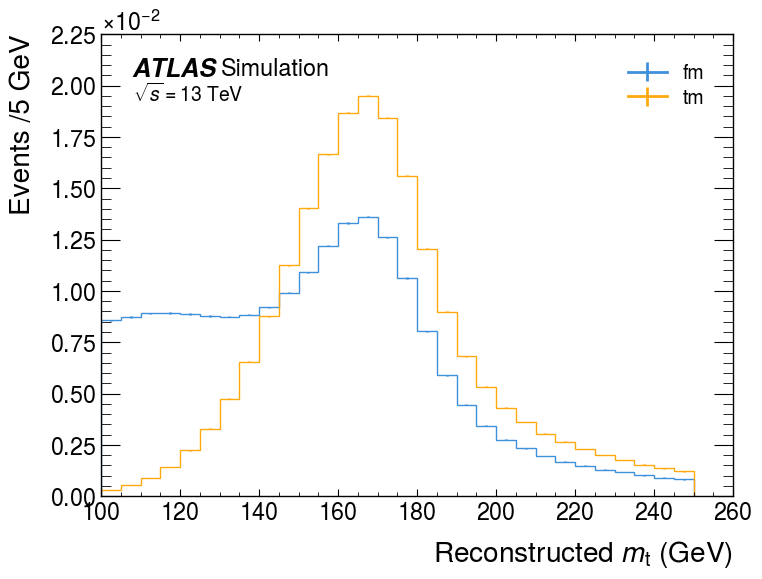

In [26]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8,6))
histogram([ak.flatten(tops_4t_1L).m, ak.flatten(hadronic_tops_4t).m], 30, ['fm', 'tm','dm','sm'], ax, density = True, x_units='GeV', print_peak=True, set_range=(100,250))
ax.set_xlabel(r'Reconstructed $m_\mathrm{t}$ (GeV)')
ax.legend(loc='upper right')
plt.subplots_adjust(hspace=0.25, wspace=0.28)
plt.savefig('3t_4t_comparison.png', dpi=300)
plt.show()

In [15]:
df = pd.DataFrame({
    r"$N_{bjets}$ ≥ 2": ak.to_numpy(nbjets_4t < 2),
    r"$N_{jets}$ ≥ 6": ak.to_numpy(njets_4t < 6),
    r"$H_T$ > 500 GeV": ak.to_numpy(~ht_mask_4t),
    r"Lep $p_T^{max}$ > 28 GeV": ak.to_numpy(~max_pt_mask_4t),
})

# Convert DataFrame into UpSet format
upset_data = from_indicators(df.columns, df)

# Plot the UpSet diagram
upset = UpSet(upset_data, show_percentages=True)

# Create the plot
fig = plt.figure(figsize=(30, 10))
plot(upset_data, element_size=70, show_percentages=True, facecolor = 'red')
plt.savefig("3tW.png")
plt.show()

NameError: name 'nbjets_4t' is not defined

#### 3tW

<Figure size 3000x1000 with 0 Axes>

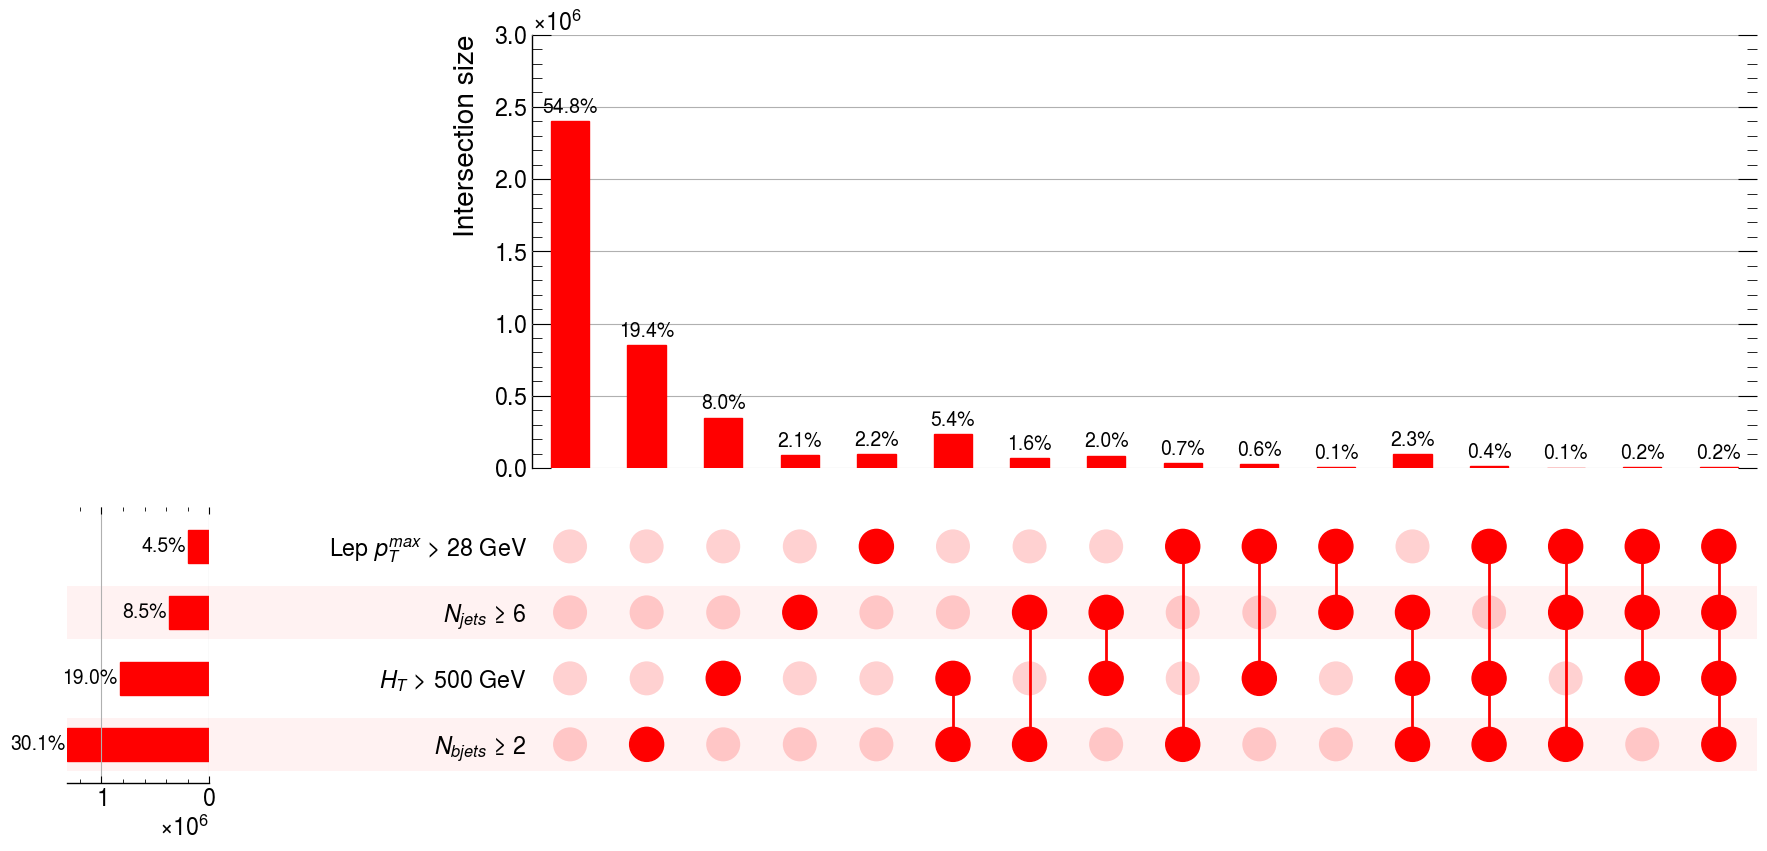

In [16]:
df = pd.DataFrame({
    r"$N_{bjets}$ ≥ 2": ak.to_numpy(nbjets_3tW < 2),
    r"$N_{jets}$ ≥ 6": ak.to_numpy(njets_3tW < 6),
    r"$H_T$ > 500 GeV": ak.to_numpy(~ht_mask_3tW),
    r"Lep $p_T^{max}$ > 28 GeV": ak.to_numpy(~max_pt_mask_3tW),
})

# Convert DataFrame into UpSet format
upset_data = from_indicators(df.columns, df)

# Plot the UpSet diagram
upset = UpSet(upset_data, show_percentages=True)

# Create the plot
fig = plt.figure(figsize=(30, 10))
plot(upset_data, element_size=70, show_percentages=True, facecolor = 'red')
plt.savefig("3tW.png")
plt.show()

#### 3tj

<Figure size 3000x1000 with 0 Axes>

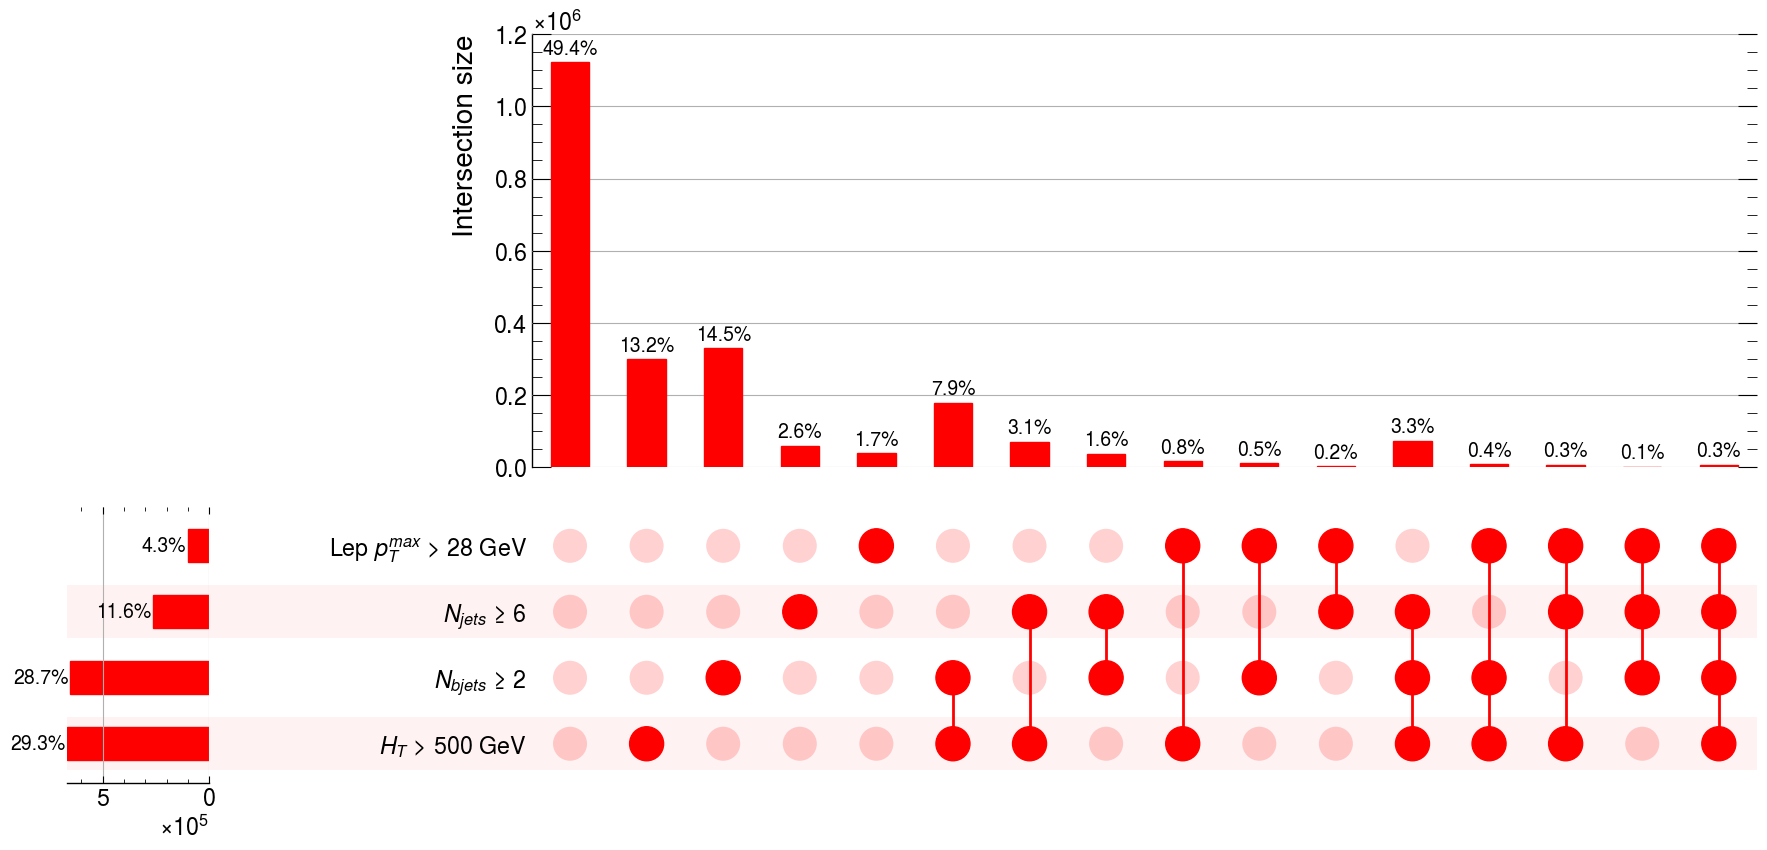

In [17]:
df = pd.DataFrame({
    r"$N_{bjets}$ ≥ 2": ak.to_numpy(nbjets_3tj < 2),
    r"$N_{jets}$ ≥ 6": ak.to_numpy(njets_3tj < 6),
    r"$H_T$ > 500 GeV": ak.to_numpy(~ht_mask_3tj),
    r"Lep $p_T^{max}$ > 28 GeV": ak.to_numpy(~max_pt_mask_3tj),
})

# Convert DataFrame into UpSet format
upset_data = from_indicators(df.columns, df)

# Plot the UpSet diagram
upset = UpSet(upset_data, show_percentages=True)

# Create the plot
fig = plt.figure(figsize=(30, 10))
plot(upset_data, element_size=70, show_percentages=True, facecolor = 'red')
plt.savefig("3tW.png")
plt.show()

Peak bin center for 3tj: 167.50 GeV
Peak bin center for 3tW: 167.50 GeV


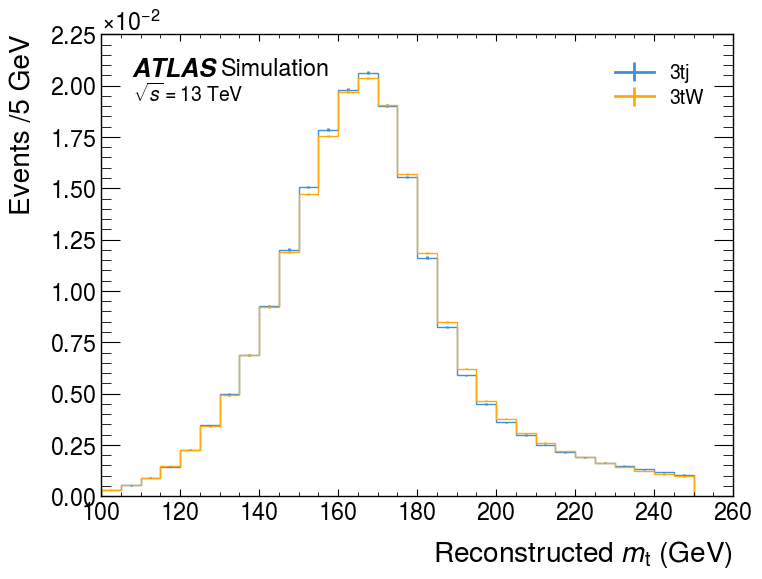

In [18]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8,6))
histogram([ak.flatten(hadronic_tops_3tj).m, ak.flatten(hadronic_tops_3tW).m], 30, ['3tj', '3tW'], ax, density = True, x_units='GeV', print_peak=True, set_range=(100,250))
ax.set_xlabel(r'Reconstructed $m_\mathrm{t}$ (GeV)')
ax.legend(loc='upper right')
plt.subplots_adjust(hspace=0.25, wspace=0.28)
plt.savefig('3t_4t_comparison.png', dpi=300)
plt.show()

Peak bin center for 3tj: 496.00 GeV
Peak bin center for 3tW: 592.00 GeV


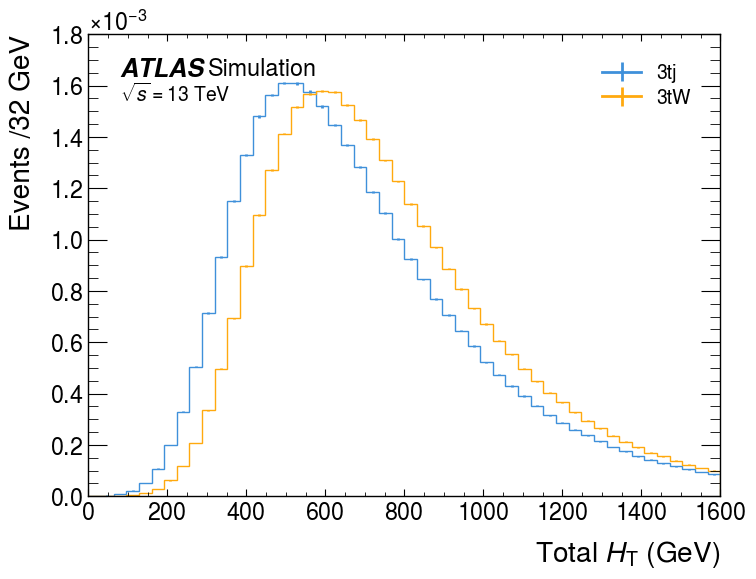

In [19]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8,6))
histogram([ht_3tj, ht_3tW], 50, ['3tj', '3tW'], ax, density = True, x_units='GeV', print_peak=True, set_range=(0,1600))
ax.set_xlabel(r'Total $H_\mathrm{T}$ (GeV)')
ax.legend(loc='upper right')
plt.subplots_adjust(hspace=0.25, wspace=0.28)
plt.savefig('3t_4t_comparison.png', dpi=300)
plt.show()

Peak bin center for fm: 167.50 GeV
Peak bin center for tm: 167.50 GeV
Peak bin center for dm: 167.50 GeV


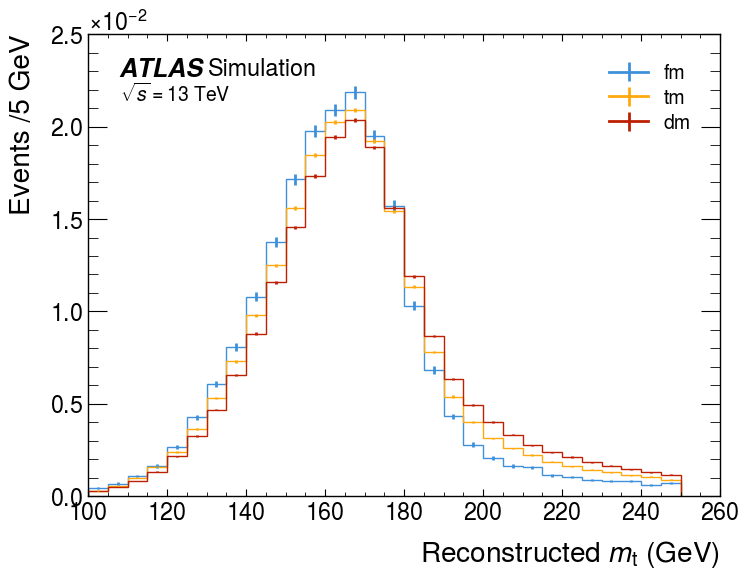

In [20]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8,6))
histogram([ak.flatten(hadronic_tops_3tj[ak.num(hadronic_tops_3tj)==3]).m, ak.flatten(hadronic_tops_3tj[ak.num(hadronic_tops_3tj)==2]).m, ak.flatten(hadronic_tops_3tj[ak.num(hadronic_tops_3tj)==1]).m], 30, ['fm', 'tm', 'dm', 'sm'], ax, density = True, x_units='GeV', print_peak=True, set_range=(100,250))
ax.set_xlabel(r'Reconstructed $m_\mathrm{t}$ (GeV)')
ax.legend(loc='upper right')
plt.subplots_adjust(hspace=0.25, wspace=0.28)
plt.savefig('3t_4t_comparison.png', dpi=300)
plt.show()